# Data Pre-Processing

### Import packages

In [1217]:
import pandas as pd
import os
from io import StringIO
import re
import sys

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from stable_baselines3 import DQN

import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import ipywidgets as widgets
from IPython.display import display

### Chose Instance and prep

In [1218]:
# # ROADEF 2009 data

# # Instance / Disruptions                      # Aircrafts  # Airports  # Flight Delays       
# data_folder = 'Data/A01_6088570'              #            #           # 63
# data_folder = 'Data/A02_6088570'              #            #           # 107
# data_folder = 'Data/A03_6088570'              # 1          #           # 83
# data_folder = 'Data/A04_6088570'              #            # 4         # 41
# data_folder = 'Data/A05_6088570'              #            # 407       #


# # Example Instances / Disruptions             # Aircrafts  # Airports  # Flight Delays      
# data_folder = 'Data/PoC-scenario'             # 1          #           # 1
data_folder = 'Data/Busy-scenario'
# data_folder = 'Data/Example-scenario-1'       # 1          #           #
# data_folder = 'Data/Example-scenario-2'       # 1          #           #
# data_folder = 'Data/Example-scenario-3'       # 1          #           #




# Function to read a CSV file, skip comment lines starting with '%', and stopping at lines starting with '#'
def read_csv_with_comments(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Filter out comment lines and stop at the ending line
    data_lines = []
    for line in lines:
        if line.startswith('#'):
            break
        if not line.startswith('%'):
            data_lines.append(line.strip())

    # Check if data_lines is empty
    if len(data_lines) == 0:
        return None  # Return None if the file has no data

    return data_lines


# Data files
aircraft_file = data_folder + '/aircraft.csv'
airports_file = data_folder + '/airports.csv'
alt_aircraft_file = data_folder + '/alt_aircraft.csv'
alt_airports_file = data_folder + '/alt_airports.csv'
alt_flights_file = data_folder + '/alt_flights.csv'
config_file = data_folder + '/config.csv'
dist_file = data_folder + '/dist.csv'
flights_file = data_folder + '/flights.csv'
itineraries_file = data_folder + '/itineraries.csv'
positions_file = data_folder + '/position.csv'
rotations_file = data_folder + '/rotations.csv'



## Each file has its own format
 

### Config file

In [1219]:
# Function to convert config file lines to a dictionary with corresponding values
def parse_config(data_lines):
    config_dict = {}
    config_dict['RecoveryPeriod'] = {
        'StartDate': data_lines[0].split()[0],
        'StartTime': data_lines[0].split()[1],
        'EndDate': data_lines[0].split()[2],
        'EndTime': data_lines[0].split()[3]
    }

    def parse_costs(line):
        parts = re.split(r'\s+', line)
        costs = []
        for i in range(0, len(parts), 3):
            costs.append({'Cabin': parts[i], 'Type': parts[i+1], 'Cost': float(parts[i+2])})
        return costs

    config_dict['DelayCosts'] = parse_costs(data_lines[1])
    config_dict['CancellationCostsOutbound'] = parse_costs(data_lines[2])
    config_dict['CancellationCostsInbound'] = parse_costs(data_lines[3])

    def parse_downgrading_costs(line):
        parts = re.split(r'\s+', line)
        costs = []
        for i in range(0, len(parts), 4):
            costs.append({'FromCabin': parts[i], 'ToCabin': parts[i+1], 'Type': parts[i+2], 'Cost': float(parts[i+3])})
        return costs

    config_dict['DowngradingCosts'] = parse_downgrading_costs(data_lines[4])
    config_dict['PenaltyCosts'] = [float(x) for x in re.split(r'\s+', data_lines[5])]
    config_dict['Weights'] = [float(x) for x in re.split(r'\s+', data_lines[6])]
    return config_dict

# Read the config file and parse the data
config_lines = read_csv_with_comments(config_file)
if config_lines:
    config_dict = parse_config(config_lines)
    # print(config_dict)
else:
    # give error
    print('Config file is empty')

### Airports file

In [1220]:
# Function to convert aircraft file lines to a dictionary with corresponding values
def parse_airports(data_lines):
    airports_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        airport = parts[0]
        capacities = []
        for i in range(1, len(parts), 4):
            capacities.append({
                'Dep/h': int(parts[i]),
                'Arr/h': int(parts[i+1]),
                'StartTime': parts[i+2],
                'EndTime': parts[i+3]
            })
        airports_dict[airport] = capacities
    return airports_dict


airports_lines = read_csv_with_comments(airports_file)
if airports_lines:
    airports_dict = parse_airports(airports_lines)
    # print(airports_dict)
else:
    airports_dict = None



### Distance file

In [1221]:
# Function to convert dist file lines to a dictionary with corresponding values
def parse_dist(data_lines):
    dist_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        origin = parts[0]
        destination = parts[1]
        dist = int(parts[2])
        type_ = parts[3]
        dist_dict[(origin, destination)] = {'Dist': dist, 'Type': type_}
    return dist_dict



dist_lines = read_csv_with_comments(dist_file)
if dist_lines:
    dist_dict = parse_dist(dist_lines)
    # print(dist_dict)
else:
    dist_dict = None

### Flights file

In [1222]:
# Function to convert flights file lines to a dictionary with corresponding values
def parse_flights(data_lines):
    flights_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        flight = int(parts[0])
        flights_dict[flight] = {
            'Orig': parts[1],
            'Dest': parts[2],
            'DepTime': parts[3],
            'ArrTime': parts[4],
            'PrevFlight': int(parts[5])
        }
    return flights_dict


flights_lines = read_csv_with_comments(flights_file)
if flights_lines:
    flights_dict = parse_flights(flights_lines)
    # print(flights_dict)
else:
    flights_dict = None


### Aircraft file

In [1223]:
# Function to convert aircraft file lines to a dictionary with corresponding values
def parse_aircraft(data_lines):
    aircraft_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        aircraft = parts[0]
        aircraft_dict[aircraft] = {
            'Model': parts[1],
            'Family': parts[2],
            'Config': parts[3],
            'Dist': int(parts[4]),
            'Cost/h': float(parts[5]),
            'TurnRound': int(parts[6]),
            'Transit': int(parts[7]),
            'Orig': parts[8],
            'Maint': parts[9] if len(parts) > 9 else None
        }
    return aircraft_dict

aircraft_lines = read_csv_with_comments(aircraft_file)
if aircraft_lines:
    aircraft_dict = parse_aircraft(aircraft_lines)
    # print(aircraft_dict)
else:
    aircraft_dict = None
    
print(len(aircraft_dict))
print(aircraft_dict)


6
{'B767#1': {'Model': 'B767', 'Family': 'Boeing', 'Config': '10/20/160', 'Dist': 12250, 'Cost/h': 3000.0, 'TurnRound': 75, 'Transit': 50, 'Orig': 'CDG', 'Maint': 'CDG-10/01/08-06:00-10/01/08-10:00-20'}, 'B767#2': {'Model': 'B767', 'Family': 'Boeing', 'Config': '10/20/160', 'Dist': 12250, 'Cost/h': 3000.0, 'TurnRound': 75, 'Transit': 50, 'Orig': 'BKK', 'Maint': 'NULL'}, 'B767#3': {'Model': 'A320', 'Family': 'Airbus', 'Config': '0/20/160', 'Dist': 5700, 'Cost/h': 2000.0, 'TurnRound': 40, 'Transit': 40, 'Orig': 'NCE', 'Maint': 'NCE-10/01/08-17:00-11/01/08-12:00-10'}, 'B767#4': {'Model': 'A320', 'Family': 'Airbus', 'Config': '0/20/160', 'Dist': 5700, 'Cost/h': 2000.0, 'TurnRound': 40, 'Transit': 40, 'Orig': 'NCE', 'Maint': 'NULL'}, 'B767#5': {'Model': 'B777', 'Family': 'Boeing', 'Config': '20/45/310', 'Dist': 14000, 'Cost/h': 4000.0, 'TurnRound': 90, 'Transit': 60, 'Orig': 'CDG', 'Maint': 'NULL'}, 'B767#6': {'Model': 'B777', 'Family': 'Boeing', 'Config': '20/45/310', 'Dist': 14000, 'Cost/

### Rotations file

In [1224]:
# Function to convert rotations file lines to a dictionary with corresponding values
def parse_rotations(data_lines):
    rotations_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        flight = int(parts[0])
        rotations_dict[flight] = {
            'DepDate': parts[1],
            'Aircraft': parts[2]
        }
    return rotations_dict

rotations_lines = read_csv_with_comments(rotations_file)
if rotations_lines:
    rotations_dict = parse_rotations(rotations_lines)
    # print(rotations_dict)
else:
    rotations_dict = None


### Itineraries file

In [1225]:
# Function to convert itineraries file lines to a dictionary with corresponding values
def parse_itineraries(data_lines):
    itineraries_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        ident = int(parts[0])
        itineraries_dict[ident] = {
            'Type': parts[1],
            'Price': float(parts[2]),
            'Count': int(parts[3]),
            'Flights': parts[4:]
        }
    return itineraries_dict

itineraries_lines = read_csv_with_comments(itineraries_file)
if itineraries_lines:
    itineraries_dict = parse_itineraries(itineraries_lines)
    # print(itineraries_dict)
else:
    itineraries_dict = None



### Positions file

In [1226]:
# Function to convert positions file lines to a dictionary with corresponding values
def parse_positions(data_lines):
    positions_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        airport = parts[0]
        model = parts[1]
        config = parts[2]
        count = int(parts[3])
        if airport not in positions_dict:
            positions_dict[airport] = []
        positions_dict[airport].append({'Model': model, 'Config': config, 'Count': count})
    return positions_dict


positions_lines = read_csv_with_comments(positions_file)
if positions_lines:
    positions_dict = parse_positions(positions_lines)
    # print(positions_dict)
else:
    positions_dict = None


    


### Flights disruptions file

In [1227]:
# Function to convert flight disruptions file lines to a dictionary with corresponding values
def parse_alt_flights(data_lines):
    alt_flights_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        flight = int(parts[0])
        alt_flights_dict[flight] = {
            'DepDate': parts[1],
            'Delay': int(parts[2])
        }
    return alt_flights_dict

alt_flights_lines = read_csv_with_comments(alt_flights_file)
if alt_flights_lines:
    alt_flights_dict = parse_alt_flights(alt_flights_lines)
    # print(alt_flights_dict)
else:
    alt_flights_dict = None




### Aircraft disruptions file

In [1228]:
# Function to convert aircraft disruptions file lines to a dictionary with corresponding values
def parse_alt_aircraft(data_lines):
    alt_aircraft_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        aircraft = parts[0]
        alt_aircraft_dict[aircraft] = {
            'StartDate': parts[1],
            'StartTime': parts[2],
            'EndDate': parts[3],
            'EndTime': parts[4]
        }
    return alt_aircraft_dict

alt_aircraft_lines = read_csv_with_comments(alt_aircraft_file)
if alt_aircraft_lines:
    alt_aircraft_dict = parse_alt_aircraft(alt_aircraft_lines)
else:
    alt_aircraft_dict = None

print(alt_aircraft_dict)


{'B767#3': {'StartDate': '10/01/08', 'StartTime': '06:00', 'EndDate': '10/01/08', 'EndTime': '16:00'}}


### Airport disruptions file

In [1229]:
# Function to convert airport disruptions file lines to a dictionary with corresponding values
def parse_alt_airports(data_lines):
    alt_airports_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        airport = parts[0]
        if airport not in alt_airports_dict:
            alt_airports_dict[airport] = []
        alt_airports_dict[airport].append({
            'StartDate': parts[1],
            'StartTime': parts[2],
            'EndDate': parts[3],
            'EndTime': parts[4],
            'Dep/h': int(parts[5]),
            'Arr/h': int(parts[6])
        })
    return alt_airports_dict

alt_airports_lines = read_csv_with_comments(alt_airports_file)
if alt_airports_lines:
    alt_airports_dict = parse_alt_airports(alt_airports_lines)
    # print(alt_airports_dict)
else:
    alt_airports_dict = None


print(alt_airports_dict)

None


In [1230]:
# print the distance from cdg to lhr
# print(dist_dict[('CDG', 'LHR')])
print(flights_dict)
print(len(flights_dict))
print(flights_dict)



{1: {'Orig': 'BKK', 'Dest': 'CDG', 'DepTime': '18:00', 'ArrTime': '01:15+1', 'PrevFlight': 0}, 2: {'Orig': 'NCE', 'Dest': 'CDG', 'DepTime': '08:00', 'ArrTime': '09:30', 'PrevFlight': 0}, 3: {'Orig': 'CDG', 'Dest': 'LHR', 'DepTime': '6:20', 'ArrTime': '07:20', 'PrevFlight': 0}, 4: {'Orig': 'CDG', 'Dest': 'LHR', 'DepTime': '08:30', 'ArrTime': '10:30', 'PrevFlight': 0}, 5: {'Orig': 'LHR', 'Dest': 'JFK', 'DepTime': '12:00', 'ArrTime': '15:30', 'PrevFlight': 0}, 6: {'Orig': 'NCE', 'Dest': 'LHR', 'DepTime': '07:30', 'ArrTime': '11:15', 'PrevFlight': 0}, 7: {'Orig': 'CDG', 'Dest': 'LHR', 'DepTime': '6:00', 'ArrTime': '07:20', 'PrevFlight': 0}, 8: {'Orig': 'LHR', 'Dest': 'CDG', 'DepTime': '12:30', 'ArrTime': '13:30', 'PrevFlight': 0}, 9: {'Orig': 'CDG', 'Dest': 'NCE', 'DepTime': '14:35', 'ArrTime': '16:05', 'PrevFlight': 0}, 10: {'Orig': 'LHR', 'Dest': 'NCE', 'DepTime': '13:10', 'ArrTime': '14:55', 'PrevFlight': 0}, 11: {'Orig': 'JFK', 'Dest': 'LHR', 'DepTime': '16:30', 'ArrTime': '19:00', 'Pr

### Merging all into data_dict

In [1231]:
# merge all the data into a single dictionary with the keys as the file names
data_dict = {
    'config': config_dict,              # this is the config data with the costs and weights
    'aircraft': aircraft_dict,          # this is the aircraft data with the aircrafts
    'airports': airports_dict,          # this is the airport data with the airports
    'dist': dist_dict,                  # this is the distance data with the distances
    'flights': flights_dict,            # this is the flight data with the flights
    'rotations': rotations_dict,        # this is the rotation data with the rotations
    'itineraries': itineraries_dict,    # this is the itinerary data with the itineraries
    'positions': positions_dict,        # this is the position data with the positions
    'alt_flights': alt_flights_dict,    # this is the flight disruption data with the flight disruptions
    'alt_aircraft': alt_aircraft_dict,  # this is the aircraft disruption data with the aircraft disruptions
    'alt_airports': alt_airports_dict   # this is the airport disruption data with the airport disruptions
}

# print the structure of the data dictionary by printing the keys, and the keys inside the keys etc
print("All the keys in data_dict")
for key in data_dict:
    print(key)
    if data_dict[key] is not None:
        for sub_key in data_dict[key]:
            print(f'  {sub_key}')
            # only print the first 3 sub_sub_keys
            if isinstance(data_dict[key][sub_key], dict):
                for sub_sub_key in data_dict[key][sub_key]:
                    print(f'    {sub_sub_key}')
    print()





All the keys in data_dict
config
  RecoveryPeriod
    StartDate
    StartTime
    EndDate
    EndTime
  DelayCosts
  CancellationCostsOutbound
  CancellationCostsInbound
  DowngradingCosts
  PenaltyCosts
  Weights

aircraft
  B767#1
    Model
    Family
    Config
    Dist
    Cost/h
    TurnRound
    Transit
    Orig
    Maint
  B767#2
    Model
    Family
    Config
    Dist
    Cost/h
    TurnRound
    Transit
    Orig
    Maint
  B767#3
    Model
    Family
    Config
    Dist
    Cost/h
    TurnRound
    Transit
    Orig
    Maint
  B767#4
    Model
    Family
    Config
    Dist
    Cost/h
    TurnRound
    Transit
    Orig
    Maint
  B767#5
    Model
    Family
    Config
    Dist
    Cost/h
    TurnRound
    Transit
    Orig
    Maint
  B767#6
    Model
    Family
    Config
    Dist
    Cost/h
    TurnRound
    Transit
    Orig
    Maint

airports
  BKK
  CDG
  JFK
  LHR
  NCE
  SYD

dist
  ('BKK', 'CDG')
    Dist
    Type
  ('BKK', 'JFK')
    Dist
    Type
  ('BKK', 'LHR')
 

# Visualisation

## Flight schedule and delays

## AC rotations and unavailability

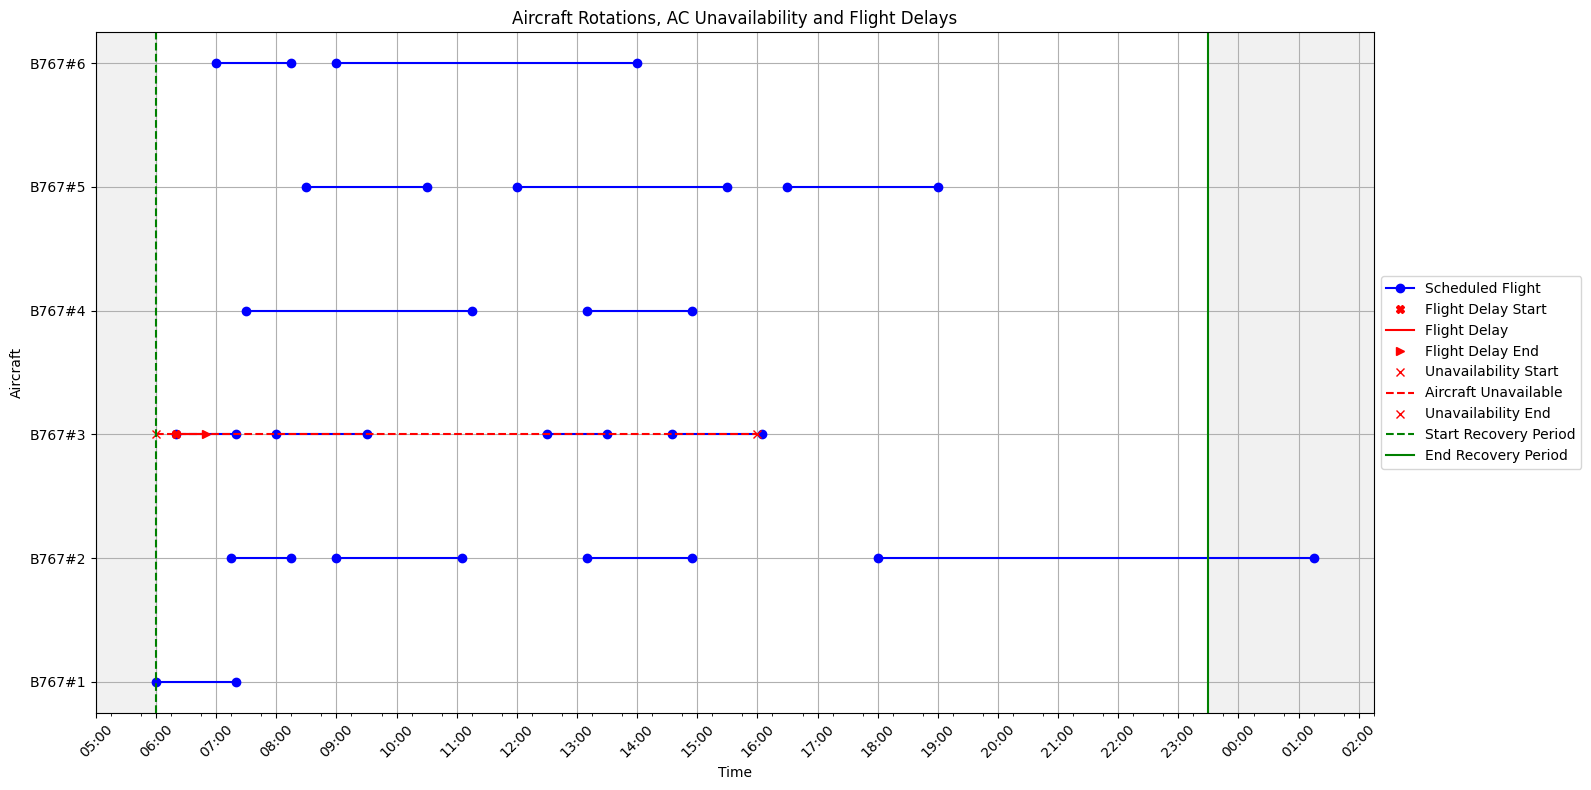

In [1232]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Function to parse time strings, handling '+1' for next day times
def parse_time_with_day_offset(time_str, reference_date):
    if '+1' in time_str:
        time_str = time_str.replace('+1', '').strip()
        time_obj = datetime.strptime(time_str, '%H:%M')
        return datetime.combine(reference_date, time_obj.time()) + timedelta(days=1)
    else:
        return datetime.strptime(time_str, '%H:%M').replace(year=reference_date.year, month=reference_date.month, day=reference_date.day)

# Extracting start and end time from the recovery period
start_date = config_dict['RecoveryPeriod']['StartDate']
start_time = config_dict['RecoveryPeriod']['StartTime']
end_date = config_dict['RecoveryPeriod']['EndDate']
end_time = config_dict['RecoveryPeriod']['EndTime']

start_datetime = datetime.strptime(start_date + ' ' + start_time, '%d/%m/%y %H:%M')
end_datetime = datetime.strptime(end_date + ' ' + end_time, '%d/%m/%y %H:%M')

# Determine the earliest and latest times from the flight data
earliest_datetime = start_datetime
latest_datetime = end_datetime

for flight_info in flights_dict.values():
    dep_datetime_str = flight_info['DepTime']
    arr_datetime_str = flight_info['ArrTime']
    
    dep_datetime = parse_time_with_day_offset(dep_datetime_str, start_datetime)
    arr_datetime = parse_time_with_day_offset(arr_datetime_str, dep_datetime)
    
    if dep_datetime < earliest_datetime:
        earliest_datetime = dep_datetime
    if arr_datetime > latest_datetime:
        latest_datetime = arr_datetime

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Create a mapping from aircraft to index
aircraft_ids = sorted(list(set([rotation_info['Aircraft'] for rotation_info in rotations_dict.values()])), reverse=False)
aircraft_indices = {aircraft_id: index + 1 for index, aircraft_id in enumerate(aircraft_ids)}

# Plot each flight's schedule based on aircraft in blue
for rotation_id, rotation_info in rotations_dict.items():
    flight_id = rotation_id
    aircraft_id = rotation_info['Aircraft']
    
    if flight_id in flights_dict:
        flight_info = flights_dict[flight_id]
        dep_datetime_str = flight_info['DepTime']
        arr_datetime_str = flight_info['ArrTime']
        
        dep_datetime = parse_time_with_day_offset(dep_datetime_str, start_datetime)
        arr_datetime = parse_time_with_day_offset(arr_datetime_str, dep_datetime)
        
        ax.plot([dep_datetime, arr_datetime], [aircraft_indices[aircraft_id], aircraft_indices[aircraft_id]], color='blue', marker='o', label='Scheduled Flight' if rotation_id == 1 else "")

# Plot disruptions in red for flight delays
if alt_flights_dict:
    for flight_id, disruption_info in alt_flights_dict.items():
        if flight_id in flights_dict:
            dep_datetime_str = flights_dict[flight_id]['DepTime']
            dep_datetime = parse_time_with_day_offset(dep_datetime_str, start_datetime)
            delay_duration = timedelta(minutes=disruption_info['Delay'])
            delayed_datetime = dep_datetime + delay_duration
            
            aircraft_id = rotations_dict[flight_id]['Aircraft']  # Get the aircraft ID for the flight
            ax.plot(dep_datetime, aircraft_indices[aircraft_id], 'X', color='red', label='Flight Delay Start' if flight_id == list(alt_flights_dict.keys())[0] else "")
            ax.plot([dep_datetime, delayed_datetime], [aircraft_indices[aircraft_id], aircraft_indices[aircraft_id]], color='red', linestyle='-', label='Flight Delay ' if flight_id == list(alt_flights_dict.keys())[0] else "")
            ax.plot(delayed_datetime, aircraft_indices[aircraft_id], '>', color='red', label='Flight Delay End' if flight_id == list(alt_flights_dict.keys())[0] else "")


# Plot unavailability in red for aircraft
if alt_aircraft_dict:
    for aircraft_id, unavailability_info in alt_aircraft_dict.items():
        start_date = unavailability_info['StartDate']
        start_time = unavailability_info['StartTime']
        end_date = unavailability_info['EndDate']
        end_time = unavailability_info['EndTime']
        
        unavail_start_datetime = datetime.strptime(start_date + ' ' + start_time, '%d/%m/%y %H:%M')
        unavail_end_datetime = datetime.strptime(end_date + ' ' + end_time, '%d/%m/%y %H:%M')
        
        ax.plot(unavail_start_datetime, aircraft_indices[aircraft_id], 'rx', label='Unavailability Start' if aircraft_id == list(alt_aircraft_dict.keys())[0] else "")
        ax.plot([unavail_start_datetime, unavail_end_datetime], [aircraft_indices[aircraft_id], aircraft_indices[aircraft_id]], color='red', linestyle='--', label='Aircraft Unavailable' if aircraft_id == list(alt_aircraft_dict.keys())[0] else "")
        ax.plot(unavail_end_datetime, aircraft_indices[aircraft_id], 'rx', label='Unavailability End' if aircraft_id == list(alt_aircraft_dict.keys())[0] else "")

# Formatting the plot
ax.set_xlim(earliest_datetime - timedelta(hours=1), latest_datetime + timedelta(hours=1))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.axvline(start_datetime, color='green', linestyle='--', label='Start Recovery Period')
ax.axvline(end_datetime, color='green', linestyle='-', label='End Recovery Period')

# Background outside recovery period slightly greyed out
ax.axvspan(end_datetime, latest_datetime + timedelta(hours=1), color='lightgrey', alpha=0.3)
ax.axvspan(earliest_datetime - timedelta(hours=1), start_datetime, color='lightgrey', alpha=0.3)


# Setting the y-ticks to be the indices with corresponding aircraft IDs as labels
plt.yticks(range(1, len(aircraft_ids) + 1), aircraft_ids)

plt.xlabel('Time')
plt.ylabel('Aircraft')
plt.title('Aircraft Rotations, AC Unavailability and Flight Delays')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Create legend on the right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


## Flights and airports unavailability

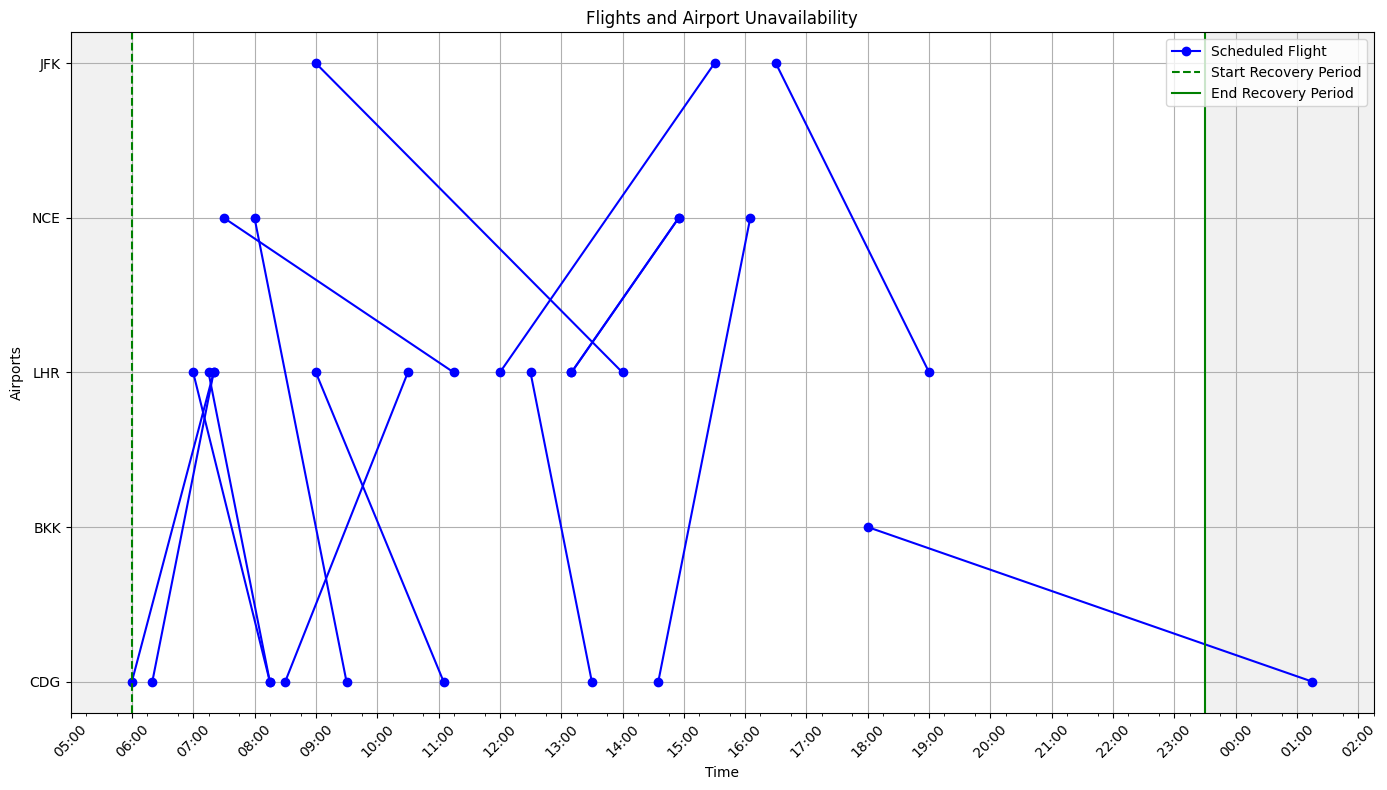

In [1233]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Function to parse time strings, handling '+1' for next day times
def parse_time_with_day_offset(time_str, reference_date):
    if '+1' in time_str:
        time_str = time_str.replace('+1', '').strip()
        time_obj = datetime.strptime(time_str, '%H:%M')
        return datetime.combine(reference_date, time_obj.time()) + timedelta(days=1)
    else:
        return datetime.strptime(time_str, '%H:%M').replace(year=reference_date.year, month=reference_date.month, day=reference_date.day)

# Extracting start and end time from the recovery period
start_date = config_dict['RecoveryPeriod']['StartDate']
start_time = config_dict['RecoveryPeriod']['StartTime']
end_date = config_dict['RecoveryPeriod']['EndDate']
end_time = config_dict['RecoveryPeriod']['EndTime']

start_datetime = datetime.strptime(start_date + ' ' + start_time, '%d/%m/%y %H:%M')
end_datetime = datetime.strptime(end_date + ' ' + end_time, '%d/%m/%y %H:%M')

# Determine the earliest and latest times from the flight data
earliest_datetime = start_datetime
latest_datetime = end_datetime

for flight_info in flights_dict.values():
    dep_datetime_str = flight_info['DepTime']
    arr_datetime_str = flight_info['ArrTime']
    
    dep_datetime = parse_time_with_day_offset(dep_datetime_str, start_datetime)
    arr_datetime = parse_time_with_day_offset(arr_datetime_str, dep_datetime)
    
    if dep_datetime < earliest_datetime:
        earliest_datetime = dep_datetime
    if arr_datetime > latest_datetime:
        latest_datetime = arr_datetime

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Create a mapping from airports to index
airports = list(set([flight_info['Orig'] for flight_info in flights_dict.values()] + [flight_info['Dest'] for flight_info in flights_dict.values()]))
airport_indices = {airport: index + 1 for index, airport in enumerate(airports)}

# Plot each flight's schedule based on airports in blue
for flight_id, flight_info in flights_dict.items():
    orig_airport = flight_info['Orig']
    dest_airport = flight_info['Dest']
    dep_datetime_str = flight_info['DepTime']
    arr_datetime_str = flight_info['ArrTime']
    
    dep_datetime = parse_time_with_day_offset(dep_datetime_str, start_datetime)
    arr_datetime = parse_time_with_day_offset(arr_datetime_str, dep_datetime)
    
    ax.plot([dep_datetime, arr_datetime], [airport_indices[orig_airport], airport_indices[dest_airport]], color='blue', marker='o', label='Scheduled Flight' if flight_id == 1 else "")

# Track which labels have been added to the legend
labels_added = set()

# Plot airport disruptions with different styles
if alt_airports_dict:
    for airport, disruptions in alt_airports_dict.items():
        for disruption_info in disruptions:
            start_date = disruption_info['StartDate']
            start_time = disruption_info['StartTime']
            end_date = disruption_info['EndDate']
            end_time = disruption_info['EndTime']
            dep_h = disruption_info['Dep/h']
            arr_h = disruption_info['Arr/h']
            
            unavail_start_datetime = datetime.strptime(start_date + ' ' + start_time, '%d/%m/%y %H:%M')
            unavail_end_datetime = datetime.strptime(end_date + ' ' + end_time, '%d/%m/%y %H:%M')

            if dep_h == 0 and arr_h == 0:
                linestyle = 'solid'
                linewidth = 3
                label = 'Completely Closed'
            elif dep_h == 0 or arr_h == 0:
                linestyle = 'solid'
                linewidth = 1
                label = 'Partially Closed (Dep/Arr)'
            else:
                linestyle = 'dashed'
                linewidth = 1
                label = 'Constrained'
            
            # Only add each label once
            if label not in labels_added:
                ax.plot([unavail_start_datetime, unavail_end_datetime], [airport_indices[airport], airport_indices[airport]], color='red', linestyle=linestyle, linewidth=linewidth, label=label)
                labels_added.add(label)
            else:
                ax.plot([unavail_start_datetime, unavail_end_datetime], [airport_indices[airport], airport_indices[airport]], color='red', linestyle=linestyle, linewidth=linewidth)
            ax.plot(unavail_start_datetime, airport_indices[airport], 'rx')
            ax.plot(unavail_end_datetime, airport_indices[airport], 'rx')

# Formatting the plot
# xlim is earliest_datetime - 1 hour and latest_datetime + 1 hour
ax.set_xlim(earliest_datetime - timedelta(hours=1), latest_datetime + timedelta(hours=1))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.axvline(start_datetime, color='green', linestyle='--', label='Start Recovery Period')
ax.axvline(end_datetime, color='green', linestyle='-', label='End Recovery Period')

# Background outside recovery period slightly greyed out
ax.axvspan(end_datetime, latest_datetime + timedelta(hours=1), color='lightgrey', alpha=0.3)
ax.axvspan(earliest_datetime - timedelta(hours=1), start_datetime, color='lightgrey', alpha=0.3)

# Setting the y-ticks to be the indices with corresponding airport codes as labels
plt.yticks(range(1, len(airport_indices) + 1), airport_indices.keys())

plt.xlabel('Time')
plt.ylabel('Airports')
plt.title('Flights and Airport Unavailability')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
ax.legend()

plt.show()


## State Plotter
Used during the RL process

In [1234]:
offset_baseline = 0
offset_id_number = - 0.05
offset_delayed_flight = 0
offset_marker_minutes = 4

class StatePlotter:
    def __init__(self, aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, start_datetime, end_datetime):
        self.aircraft_dict = aircraft_dict
        self.initial_flights_dict = flights_dict
        self.rotations_dict = rotations_dict
        self.alt_aircraft_dict = alt_aircraft_dict
        self.start_datetime = start_datetime
        self.end_datetime = end_datetime

        aircraft_id_to_idx = {aircraft_id: idx + 1 for idx, aircraft_id in enumerate(aircraft_dict.keys())}
        self.aircraft_id_to_idx = aircraft_id_to_idx
        
        # Calculate the earliest and latest datetimes
        self.earliest_datetime = min(
            min(parse_time_with_day_offset(flight_info['DepTime'], start_datetime) for flight_info in flights_dict.values()),
            start_datetime
        )
        self.latest_datetime = max(
            max(parse_time_with_day_offset(flight_info['ArrTime'], start_datetime) for flight_info in flights_dict.values()),
            end_datetime
        )

    def plot_state(self, flights_dict, swapped_flights, environment_delayed_flights, current_datetime):
        updated_rotations_dict = self.rotations_dict.copy()
        for swap in swapped_flights:
            flight_id, new_aircraft_id = swap
            updated_rotations_dict[flight_id]['Aircraft'] = new_aircraft_id

        all_aircraft_ids = set([rotation_info['Aircraft'] for rotation_info in updated_rotations_dict.values()]).union(set(self.aircraft_dict.keys()))
        aircraft_ids = sorted(list(all_aircraft_ids), reverse=False)
        aircraft_indices = {aircraft_id: index + 1 for index, aircraft_id in enumerate(aircraft_ids)}

        fig, ax = plt.subplots(figsize=(14, 8))

        labels = {
            'Scheduled Flight': False,
            'Swapped Flight': False,
            'Environment Delayed Flight': False,
            'Aircraft Unavailable': False,
            'Disruption Start': False,
            'Disruption End': False,
            'Delay of Flight': False
        }

        for rotation_id, rotation_info in updated_rotations_dict.items():
            flight_id = rotation_id
            aircraft_id = rotation_info['Aircraft']
            
            if flight_id in flights_dict:
                flight_info = flights_dict[flight_id]
                dep_datetime_str = flight_info['DepTime']
                arr_datetime_str = flight_info['ArrTime']
                
                dep_datetime = parse_time_with_day_offset(dep_datetime_str, self.start_datetime)
                arr_datetime = parse_time_with_day_offset(arr_datetime_str, dep_datetime)
                
                swapped = any(flight_id == swap[0] for swap in swapped_flights)
                delayed = flight_id in environment_delayed_flights
                plot_color = 'green' if swapped else 'orange' if delayed else 'blue'
                plot_label = 'Swapped Flight' if swapped else 'Environment Delayed Flight' if delayed else 'Scheduled Flight'
                
                y_offset = aircraft_indices[aircraft_id] + offset_baseline
                if delayed:
                    y_offset += offset_delayed_flight

                # Plot the line representing the flight without markers
                ax.plot([dep_datetime, arr_datetime], [y_offset, y_offset], color=plot_color, label=plot_label if (swapped and not labels['Swapped Flight']) or (delayed and not labels['Environment Delayed Flight']) or (not swapped and not delayed and not labels['Scheduled Flight']) else None)
                # Offset the markers slightly by reducing/increasing time
                marker_offset = timedelta(minutes=offset_marker_minutes)

                # Plot departure marker with slight offset
                ax.plot(dep_datetime + marker_offset, y_offset, color=plot_color, marker='>', markersize=6, markeredgewidth=0)

                # Plot arrival marker with slight offset
                ax.plot(arr_datetime - marker_offset, y_offset, color=plot_color, marker='<', markersize=6, markeredgewidth=0)

                if delayed:
                    # Draw a vertical line at the departure and arrival times to indicate delay
                    ax.vlines([dep_datetime, arr_datetime], y_offset - offset_delayed_flight, y_offset, color='orange', linestyle='-', linewidth=2)

                labels[plot_label] = True
                
                # Calculate the midpoint between departure and arrival for placing the flight ID
                mid_datetime = dep_datetime + (arr_datetime - dep_datetime) / 2

                # flight id above line
                ax.text(mid_datetime, y_offset + offset_id_number, flight_id, 
                        ha='center', va='bottom', fontsize=10, color='black')



        if self.alt_aircraft_dict:
            for aircraft_id, unavailability_info in self.alt_aircraft_dict.items():
                start_date = unavailability_info['StartDate']
                start_time = unavailability_info['StartTime']
                end_date = unavailability_info['EndDate']
                end_time = unavailability_info['EndTime']
                
                unavail_start_datetime = datetime.strptime(start_date + ' ' + start_time, '%d/%m/%y %H:%M')
                unavail_end_datetime = datetime.strptime(end_date + ' ' + end_time, '%d/%m/%y %H:%M')
                
                if aircraft_id in aircraft_indices:
                    if not labels['Aircraft Unavailable']:
                        ax.plot([unavail_start_datetime, unavail_end_datetime], [aircraft_indices[aircraft_id], aircraft_indices[aircraft_id]], color='red', linestyle='--', label='Aircraft Unavailable')
                        labels['Aircraft Unavailable'] = True
                    else:
                        ax.plot([unavail_start_datetime, unavail_end_datetime], [aircraft_indices[aircraft_id], aircraft_indices[aircraft_id]], color='red', linestyle='--')
                    if not labels['Disruption Start']:
                        ax.plot(unavail_start_datetime, aircraft_indices[aircraft_id], 'rx', label='Disruption Start')
                        labels['Disruption Start'] = True
                    else:
                        ax.plot(unavail_start_datetime, aircraft_indices[aircraft_id], 'rx')
                    if not labels['Disruption End']:
                        ax.plot(unavail_end_datetime, aircraft_indices[aircraft_id], 'rx', label='Disruption End')
                        labels['Disruption End'] = True
                    else:
                        ax.plot(unavail_end_datetime, aircraft_indices[aircraft_id], 'rx')

        ax.set_xlim(self.earliest_datetime - timedelta(hours=1), self.latest_datetime + timedelta(hours=1))
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
        ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.axvline(self.start_datetime, color='green', linestyle='--', label='Start Recovery Period')
        ax.axvline(self.end_datetime, color='green', linestyle='-', label='End Recovery Period')
        ax.axvline(current_datetime, color='black', linestyle='-', label='Current Time')

        ax.axvspan(self.end_datetime, self.latest_datetime + timedelta(hours=1), color='lightgrey', alpha=0.3)
        ax.axvspan(self.earliest_datetime - timedelta(hours=1), self.start_datetime, color='lightgrey', alpha=0.3)
        
        # Reverse the y-axis
        ax.invert_yaxis()

        # Generate y-ticks with correct aircraft string
        ytick_labels = [f"{index +1}: {aircraft_id}" for index, aircraft_id in enumerate(aircraft_ids)]

        plt.yticks(range(1, len(aircraft_ids) + 1), ytick_labels)

        plt.xlabel('Time')
        plt.ylabel('Aircraft')
        plt.title('Aircraft Rotations and Unavailability')
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()

        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()


# Reinforcement Learning

## Environment

### Create

In [1235]:
import copy
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from datetime import datetime, timedelta

# These values can either be passed during initialization or set as class attributes
MAX_AIRCRAFT = 10
MAX_FLIGHTS_PER_AIRCRAFT = 10
COLUMNS_STATE_SPACE = 1 + 2 + 2 * MAX_FLIGHTS_PER_AIRCRAFT

print(COLUMNS_STATE_SPACE)

class AircraftDisruptionEnv(gym.Env):
    def __init__(self, aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict):
        super(AircraftDisruptionEnv, self).__init__()

        # Assign global constants to class attributes
        self.max_aircraft = MAX_AIRCRAFT
        self.columns_state_space = COLUMNS_STATE_SPACE

        # Define the full recovery period
        start_date = config_dict['RecoveryPeriod']['StartDate']
        start_time = config_dict['RecoveryPeriod']['StartTime']
        end_date = config_dict['RecoveryPeriod']['EndDate']
        end_time = config_dict['RecoveryPeriod']['EndTime']

        self.start_datetime = datetime.strptime(start_date + ' ' + start_time, '%d/%m/%y %H:%M')
        self.end_datetime = datetime.strptime(end_date + ' ' + end_time, '%d/%m/%y %H:%M')
        self.timestep = timedelta(hours=1)

        self.aircraft_ids = list(aircraft_dict.keys())
        self.aircraft_id_to_idx = {aircraft_id: idx for idx, aircraft_id in enumerate(self.aircraft_ids)}

        self.earliest_datetime = min(
            min(parse_time_with_day_offset(flight_info['DepTime'], self.start_datetime) for flight_info in flights_dict.values()),
            self.start_datetime
        )

        # Update state space size to include the additional row
        self.state_space_size = (self.max_aircraft, self.columns_state_space)
        self.observation_space = spaces.Box(low=0, high=2880, shape=self.state_space_size, dtype=np.int32)  # 2880 minutes = 48 hours

        # Action space: index of the aircraft to reassign (0 to number of aircraft), so 0, 1, 2, ..., len(aircraft_ids)
        self.full_action_space = spaces.Discrete(len(self.aircraft_ids) + 1)
        self.action_space = self.full_action_space  # Initialize with the full action space

        # Store initial states of flights, rotations, and disruption data
        self.initial_aircraft_dict = copy.deepcopy(aircraft_dict)
        self.initial_flights_dict = copy.deepcopy(flights_dict)
        self.initial_rotations_dict = copy.deepcopy(rotations_dict)
        self.initial_alt_aircraft_dict = copy.deepcopy(alt_aircraft_dict)

        self.environment_delayed_flights = {}  # {flight_id: delay_minutes}
        self.penalized_delays = set()  # Track which delays have been penalized
        self.penalized_conflicts = set()  # Track which conflicts have been penalized
        self.resolved_conflicts = set()
        
        # Create a dictionary to later pair the flight id with the locations in the state space. This will be filled in the loop below
        self.flight_id_to_state_space = {}

        self.state_unnormalized = None  # To keep the unnormalized state
        self.state = None  # Normalized state

        # Initialize state
        self.reset()


    def _get_initial_state(self, rotations_dict, flights_dict, alt_aircraft_dict, start_time, end_time):
        # Initialize state with NaN for empty values and additional space for the new row
        state = np.full((self.max_aircraft, self.columns_state_space), np.nan)

        # Calculate the current time and time until the end of the recovery period in minutes
        current_time_minutes = (self.current_datetime - self.start_datetime).total_seconds() // 60
        time_until_end_minutes = (self.end_datetime - self.current_datetime).total_seconds() // 60

        # Identify the current conflicting aircraft, if any
        conflicting_aircraft_idx = -1  # Default value indicating no conflict
        for idx, aircraft_id in enumerate(self.aircraft_ids):
            if idx >= self.max_aircraft:
                continue

            if aircraft_id in alt_aircraft_dict:
                unavail_info = alt_aircraft_dict[aircraft_id]
                unavail_start_time = datetime.strptime(unavail_info['StartDate'] + ' ' + unavail_info['StartTime'], '%d/%m/%y %H:%M')
                unavail_end_time = datetime.strptime(unavail_info['EndDate'] + ' ' + unavail_info['EndTime'], '%d/%m/%y %H:%M')

                unavail_start_minutes = (unavail_start_time - self.earliest_datetime).total_seconds() // 60
                unavail_end_minutes = (unavail_end_time - self.earliest_datetime).total_seconds() // 60

                for rotation_id, rotation_info in rotations_dict.items():
                    if rotation_info['Aircraft'] == aircraft_id:
                        flight_info = flights_dict[rotation_id]
                        dep_time = parse_time_with_day_offset(flight_info['DepTime'], self.earliest_datetime)
                        arr_time = parse_time_with_day_offset(flight_info['ArrTime'], dep_time)

                        dep_time_minutes = (dep_time - self.earliest_datetime).total_seconds() // 60
                        arr_time_minutes = (arr_time - self.earliest_datetime).total_seconds() // 60

                        if (unavail_start_minutes <= arr_time_minutes and unavail_end_minutes >= dep_time_minutes):
                            if dep_time_minutes > current_time_minutes:
                                conflicting_aircraft_idx = idx
                                break
                if conflicting_aircraft_idx != -1:
                    break


        for idx, aircraft_id in enumerate(self.aircraft_ids):
            if idx >= self.max_aircraft:
                break  # We only consider the first max_aircraft aircraft
            state[idx, 0] = idx  # Store the index of the aircraft ID starting from 1

            # Add unavailability times (relative to the recovery period start)
            if aircraft_id in alt_aircraft_dict:
                unavail_info = alt_aircraft_dict[aircraft_id]
                unavail_start_time = datetime.strptime(unavail_info['StartDate'] + ' ' + unavail_info['StartTime'], '%d/%m/%y %H:%M')
                unavail_end_time = datetime.strptime(unavail_info['EndDate'] + ' ' + unavail_info['EndTime'], '%d/%m/%y %H:%M')

                unavail_start_minutes = (unavail_start_time - self.earliest_datetime).total_seconds() // 60
                unavail_end_minutes = (unavail_end_time - self.earliest_datetime).total_seconds() // 60

                state[idx, 1] = unavail_start_minutes
                state[idx, 2] = unavail_end_minutes
            else:
                state[idx, 1] = np.nan  # If there's no unavailability, set to NaN
                state[idx, 2] = np.nan

            # Get all flights for this aircraft within the recovery period
            flight_times = []
            for rotation_id, rotation_info in rotations_dict.items():
                if rotation_info['Aircraft'] == aircraft_id:
                    flight_info = flights_dict[rotation_id]
                    dep_time = parse_time_with_day_offset(flight_info['DepTime'], self.earliest_datetime)
                    arr_time = parse_time_with_day_offset(flight_info['ArrTime'], dep_time)

                    # Convert to minutes relative to earliest_datetime
                    dep_time_minutes = (dep_time - self.earliest_datetime).total_seconds() // 60
                    arr_time_minutes = (arr_time - self.earliest_datetime).total_seconds() // 60
                    flight_times.append((dep_time_minutes, arr_time_minutes))

                    # Store the flight ID and the location in the state space
                    self.flight_id_to_state_space[rotation_id] = (idx, len(flight_times) - 1)


            # Flatten the list and store in the state matrix
            flight_times_flat = [time for times in flight_times for time in times]
            state[idx, 3:len(flight_times_flat) + 3] = flight_times_flat[:20]  # Store up to 20 times (10 flights)

        return state



    def step(self, action):
        assert self.action_space.contains(action), "Invalid action"
        # print("")
        # print("Step Function")

        action_explain = "No action taken" if action == 0 else f"Action: Aircraft {self.aircraft_ids[action - 1]}"
        # print(f" - Action chosen: {action_explain}")
        conflicting_aircraft = None
        conflicting_flight_id = None
        
        conflicting_aircraft_list = []
        conflicting_flight_ids = []

        # convert current datetime to minutes
        current_datetime = (self.current_datetime - self.earliest_datetime).total_seconds() // 60
        
        # check for conflicts
        for idx, aircraft_id in enumerate(self.aircraft_ids):
            if idx >= self.max_aircraft:
                continue
            
            unavail_start = self.state[idx, 1]
            unavail_end = self.state[idx, 2]

            if not np.isnan(unavail_start) and not np.isnan(unavail_end):
                # print(f" - Checking for conflicts with Aircraft {aircraft_id}")
                for j in range(3, self.columns_state_space, 2):
                    flight_dep = self.state[idx, j]
                    flight_arr = self.state[idx, j+1]

                    if not np.isnan(flight_dep) and not np.isnan(flight_arr):
                        
                        if (unavail_start <= flight_arr and unavail_end >= flight_dep):
                            conflicting_aircraft_list.append(aircraft_id)
                            id = list(self.flight_id_to_state_space.keys())[list(self.flight_id_to_state_space.values()).index((idx, (j-3)//2))]
                            conflicting_flight_ids.append(id)
        

        # print the state
        # print(f" - Current State:")
        # print(self.state)
        
        # assign the conflicting aircraft and flight with the earliest time
        # print(f"current conflicting aircraft: {conflicting_aircraft}")
        # print(f"current conflicting flight: {conflicting_flight_id}")
        if conflicting_aircraft_list:
            conflicting_aircraft = conflicting_aircraft_list[0]
            conflicting_flight_id = conflicting_flight_ids[0]
            # for every aircraft in the conflicting aircraft list
            for i in range(1, len(conflicting_aircraft_list)):
                earliest_time = None
                # for each flight in the conflicting flight list that is not nan
                for j in range(3, self.columns_state_space, 2):
                    if not np.isnan(self.state[self.aircraft_id_to_idx[conflicting_aircraft_list[i]], j]):
                        # get the departure time of the flight and compare it with the earliest time
                        if earliest_time is None or self.state[self.aircraft_id_to_idx[conflicting_aircraft_list[i]], j] < earliest_time:
                            earliest_time = self.state[self.aircraft_id_to_idx[conflicting_aircraft_list[i]], j]
                            conflicting_aircraft = conflicting_aircraft_list[i]
                            id = list(self.flight_id_to_state_space.keys())[list(self.flight_id_to_state_space.values()).index((self.aircraft_id_to_idx[conflicting_aircraft], (j-3)//2))]
                            conflicting_flight_id = id
                            
                          
        # print(f" - List of Conflicting Aircraft: {conflicting_aircraft_list}")
        # print(f" - List of Conflicting Flights: {conflicting_flight_ids}")
        # print(f" - Conflicting Aircraft: {conflicting_aircraft}")
        # print(f" - Conflicting Flight: {conflicting_flight_id}")


        if conflicting_aircraft is None:
            # print(" - No conflicting flight found;  No action taken")
            
            reward = self._calculate_reward(self.state, action)
            done = self._is_done()
            next_datetime = self.current_datetime + self.timestep
            self.state = self._get_initial_state(self.rotations_dict, self.flights_dict, self.alt_aircraft_dict, next_datetime, next_datetime + self.timestep)
            self.current_datetime = next_datetime
            return self.state, reward, done, False, {}

        conflicting_idx = self.aircraft_id_to_idx[conflicting_aircraft]


        # if action is 0
        if action == 0:
            # print("")
            # print(" - No action taken or action is the same as the conflicting aircraft")
            

            reward = self._calculate_reward(self.state, action)
            done = self._is_done()
            next_datetime = self.current_datetime + self.timestep
            self.state = self._get_initial_state(self.rotations_dict, self.flights_dict, self.alt_aircraft_dict, next_datetime, next_datetime + self.timestep)
            self.current_datetime = next_datetime
            return self.state, reward, done, False, {}

        selected_aircraft_id = self.aircraft_ids[action - 1]
        selected_idx = self.aircraft_id_to_idx[selected_aircraft_id]

        # if the selected aircraft is the conflicting aircraft
        if selected_aircraft_id == conflicting_aircraft:
            # print("")
            # print(" - Selected Aircraft is the conflicting aircraft")

            # delay the conflicting flight to when the aircraft is available (so that is right after the unavailability period or after the flight after that)
            self.determine_and_apply_best_delay(selected_aircraft_id, conflicting_flight_id)

            

            reward = self._calculate_reward(self.state, action)
            done = self._is_done()
            next_datetime = self.current_datetime + self.timestep
            self.state = self._get_initial_state(self.rotations_dict, self.flights_dict, self.alt_aircraft_dict, next_datetime, next_datetime + self.timestep)
            self.current_datetime = next_datetime
            return self.state, reward, done, False, {}
        
        
        # print(f" - Selected Aircraft id: {selected_aircraft_id}")
        # print(f" - Selected Aircraft index: {selected_idx}")
        # print(f" - Conflicting Flight id: {conflicting_flight_id}")

        if conflicting_flight_id:
            self.swapped_flights.append((conflicting_flight_id, selected_aircraft_id))
            # print("[DEBUG] Action taken:", action, " = ", action_explain)
            # print(f"[DEBUG] Swapped flight {conflicting_flight_id} from Aircraft {conflicting_aircraft} to Aircraft {selected_aircraft_id}")

            # Update the rotation dict to reflect the swap
            self.rotations_dict[conflicting_flight_id]['Aircraft'] = selected_aircraft_id

            self.state[conflicting_idx, 3:23] = np.nan
            self.state[selected_idx, 3:23] = self.state[conflicting_idx, 3:23]

            # Determine which flight to delay: the swapped flight or the conflicting flight
            self.determine_and_apply_best_delay(selected_aircraft_id, conflicting_flight_id)

        

        next_datetime = self.current_datetime + self.timestep
        self.state = self._get_initial_state(self.rotations_dict, self.flights_dict, self.alt_aircraft_dict, next_datetime, next_datetime + self.timestep)
        self.current_datetime = next_datetime
        
        # print("Calling reward function now!")
        reward = self._calculate_reward(self.state, action)
        done = self._is_done()
        
        # print(f"[DEBUG] Ending step function. New time: {self.current_datetime}")
        return self.state, reward, done, False, {}


    def check_and_resolve_conflicts(self, aircraft_id, selected_idx):
        conflicts_found = True
        while conflicts_found:
            conflicts_found = False
            for rotation_id, rotation_info in self.rotations_dict.items():
                if rotation_info['Aircraft'] == aircraft_id:
                    flight_info = self.flights_dict[rotation_id]
                    dep_time = parse_time_with_day_offset(flight_info['DepTime'], self.current_datetime)
                    arr_time = parse_time_with_day_offset(flight_info['ArrTime'], dep_time)

                    for other_rotation_id, other_rotation_info in self.rotations_dict.items():
                        if other_rotation_id != rotation_id and other_rotation_info['Aircraft'] == aircraft_id:
                            other_flight_info = self.flights_dict[other_rotation_id]
                            other_dep_time = parse_time_with_day_offset(other_flight_info['DepTime'], self.current_datetime)
                            other_arr_time = parse_time_with_day_offset(other_flight_info['ArrTime'], other_dep_time)

                            if other_dep_time < arr_time and other_arr_time > dep_time:
                                conflict_identifier = (aircraft_id, dep_time, arr_time)
                                if conflict_identifier not in self.penalized_conflicts:
                                    # print(f"[DEBUG] Conflict found between {rotation_id} and {other_rotation_id}")
                                    self.determine_and_apply_best_delay(aircraft_id, rotation_id)
                                    conflicts_found = True
                                    break



    def determine_and_apply_best_delay(self, selected_aircraft_id, conflicting_flight_id):
        conflicting_flight_info = self.flights_dict[conflicting_flight_id]
        conf_dep_time = parse_time_with_day_offset(conflicting_flight_info['DepTime'], self.current_datetime)
        conf_arr_time = parse_time_with_day_offset(conflicting_flight_info['ArrTime'], conf_dep_time)

        for other_rotation_id, other_rotation_info in self.rotations_dict.items():
            if other_rotation_info['Aircraft'] == selected_aircraft_id and other_rotation_id != conflicting_flight_id:
                # print(f"[DEBUG] Checking conflict between {conflicting_flight_id} and {other_rotation_id}")
                other_flight_info = self.flights_dict[other_rotation_id]
                other_dep_time = parse_time_with_day_offset(other_flight_info['DepTime'], self.current_datetime)
                other_arr_time = parse_time_with_day_offset(other_flight_info['ArrTime'], other_dep_time)

                if other_dep_time < conf_arr_time and other_arr_time > conf_dep_time:
                    # print(f"[DEBUG] Conflict found between {conflicting_flight_id} and {other_rotation_id}")
                    delay_other = (conf_arr_time - other_dep_time).total_seconds() // 60
                    delay_conf = (other_arr_time - conf_dep_time).total_seconds() // 60
                    
                    delay_other = max(0, delay_other)
                    delay_conf = max(0, delay_conf)

                    # print(f" -- the delay would be {delay_other} for {other_rotation_id} and {delay_conf} for {conflicting_flight_id}")

                    if delay_other < delay_conf:
                        # print(f"[DEBUG] Delaying {other_rotation_id} by {delay_other} minutes")
                        new_dep_time = other_dep_time + timedelta(minutes=delay_other)
                        new_arr_time = other_arr_time + timedelta(minutes=delay_other)
                        self.flights_dict[other_rotation_id]['DepTime'] = self._convert_time_to_str(new_dep_time)
                        self.flights_dict[other_rotation_id]['ArrTime'] = self._convert_time_to_str(new_arr_time)
                        self.environment_delayed_flights[other_rotation_id] = delay_other
                    else:
                        # print(f"[DEBUG] Delaying {conflicting_flight_id} by {delay_conf} minutes")
                        new_conf_dep_time = conf_dep_time + timedelta(minutes=delay_conf)
                        new_conf_arr_time = conf_arr_time + timedelta(minutes=delay_conf)
                        self.flights_dict[conflicting_flight_id]['DepTime'] = self._convert_time_to_str(new_conf_dep_time)
                        self.flights_dict[conflicting_flight_id]['ArrTime'] = self._convert_time_to_str(new_conf_arr_time)
                        self.environment_delayed_flights[conflicting_flight_id] = delay_conf
                    
                    # Recursively check for any further conflicts introduced by the delay
                    self.check_and_resolve_conflicts(selected_aircraft_id, self.aircraft_id_to_idx[selected_aircraft_id])
                    break

        # Check for any further conflicts introduced by the delay
        self.check_and_resolve_conflicts(selected_aircraft_id, self.aircraft_id_to_idx[selected_aircraft_id])


    def _convert_time_to_str(self, time_obj):
        time_str = time_obj.strftime('%H:%M')
        if time_obj.date() > self.current_datetime.date():
            time_str += ' +1'
        return time_str
    
    # Function to parse time strings, handling '+1' for next day times
    def parse_time_with_day_offset(time_str, reference_date):
        if '+1' in time_str:
            time_str = time_str.replace('+1', '').strip()
            time_obj = datetime.strptime(time_str, '%H:%M')
            return datetime.combine(reference_date, time_obj.time()) + timedelta(days=1)
        else:
            return datetime.strptime(time_str, '%H:%M').replace(year=reference_date.year, month=reference_date.month, day=reference_date.day)


    def _calculate_reward(self, state, action):


        # Initialize reward
        reward = 0


        # Encourage taking different actions
        # if not hasattr(self, 'actions_taken'):
        #     self.actions_taken = set()

        # if action in self.actions_taken:
        #     reward -= 200  # Reward for taking a new action
        #     self.actions_taken.add(action)


        conflicts = 0
        current_conflicts = set()
        newly_resolved_conflicts = 0
        # print(" - action: ", action)
        # Track current conflicts across all aircraft
        for idx, aircraft_id in enumerate(self.aircraft_ids):
            if idx >= self.max_aircraft:
                break
            if not np.isnan(state[idx, 1]) and not np.isnan(state[idx, 2]):
                for j in range(3, self.columns_state_space, 2):
                    flight_dep = state[idx, j]
                    flight_arr = state[idx, j + 1]
                    if not np.isnan(flight_dep) and not np.isnan(flight_arr):
                        if flight_dep < state[idx, 2] and flight_arr > state[idx, 1]:
                            conflict_identifier = (aircraft_id, flight_dep, flight_arr)
                            current_conflicts.add(conflict_identifier)


        # print(f" - Current Conflicts: {current_conflicts}")
         
        # # Calculate how many flights each aircraft has assigned. just simple count of non-nan values in the state matrix from column 3 onwards. not dependent on the unavailability periods
        # flights_assigned = np.zeros(self.max_aircraft)

        # for idx, aircraft_id in enumerate(self.aircraft_ids):
        #     if idx >= self.max_aircraft:
        #         break
        #     count = 0
        #     for j in range(3, self.columns_state_space, 2):
        #         if not np.isnan(state[idx, j]):
        #             count += 1
        #     flights_assigned[idx] = count

        # print(f" - Flights Assigned: {flights_assigned}")            
            
        # Penalize the agent for each flight assigned to an aircraft beyond the maximum allowed

        # # the limit is (total number of flights) / (total number of aircraft) *2
        # limit_flights = len(self.flights_dict) / len(self.aircraft_ids) * 2

        # for idx, count in enumerate(flights_assigned):
        #     if count > limit_flights:
        #         excess_flights = count - limit_flights
        #         reward -= 10 * excess_flights
        #         # print(f" - Excess Flights Penalty: -{1000 * excess_flights}")



        if current_conflicts:
            # if action is 0 or action is in the current conflicts (i.e. the selected aircraft has a conflict)
            if action == 0 or aircraft_ids[action - 1] in {aircraft_id for aircraft_id, _, _ in current_conflicts}:
                conflicts = len(current_conflicts)
                reward -= 500 * conflicts
                # print(f" - Conflicts Penalty: -{1000 * conflicts}")
            else:
                reward += 1000  # Reward for resolving a conflict
                # print(" - No conflict penalty applied for action", action, "corresponding with Aircraft", self.aircraft_ids[action - 1])
                pass

        # Identify newly resolved conflicts
        for conflict in self.penalized_conflicts:
            if conflict not in current_conflicts and conflict not in self.resolved_conflicts:
                newly_resolved_conflicts += 1
                self.resolved_conflicts.add(conflict)  # Mark this conflict as resolved
                print(f" - Newly Resolved Conflict: {conflict}")

        # Update penalized conflicts
        self.penalized_conflicts = current_conflicts

        # Calculate the delay penalty
        delay_penalty = 0
        for flight_id, delay in self.environment_delayed_flights.items():
            if flight_id not in self.penalized_delays:
                delay_penalty += delay
                self.penalized_delays.add(flight_id)


        # Apply conflict penalty only if required
        if conflicts > 0 and (action == 0 or action in {aircraft_id for aircraft_id, _, _ in current_conflicts}):
            reward -= 1000 * conflicts

        # Subtract the delay penalty (once)
        reward -= delay_penalty * 5

        # Add newly resolved conflicts reward (reward only once)
        reward += 5000 * newly_resolved_conflicts

        # # Print reward breakdown for debugging purposes
        # print(f" - Reward Breakdown:")
        # print(f"    - Excess Flights Penalty: -{1000 * excess_flights}")
        # print(f"    - Conflicts Penalty: -{1000 * conflicts}")
        # print(f"    - Delay Penalty: -{10 * delay_penalty}")
        # print(f"    - Newly Resolved Conflicts Reward: {5000 * newly_resolved_conflicts}")
        
        # Return the final reward
        return reward




    def _is_done(self):
        return self.current_datetime >= self.end_datetime



    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        else:
            np.random.seed()  # This will seed with the current time or entropy source, making it random
        self.current_datetime = self.start_datetime

        self.actions_taken = set()  # Reset the actions taken at the beginning of each episode
    
        # Deep copy the initial dictionaries to reset them
        self.aircraft_dict = copy.deepcopy(self.initial_aircraft_dict)
        self.flights_dict = copy.deepcopy(self.initial_flights_dict)
        self.rotations_dict = copy.deepcopy(self.initial_rotations_dict)
        self.alt_aircraft_dict = copy.deepcopy(self.initial_alt_aircraft_dict)
    


        self.state = self._get_initial_state(self.rotations_dict, self.flights_dict, self.alt_aircraft_dict, self.current_datetime, self.current_datetime + self.timestep)
        self.swapped_flights = []  # Reset the swapped flights list
        self.environment_delayed_flights = {}  # Reset the delayed flights list
        self.penalized_delays = set()  # Reset the penalized delays
        self.penalized_conflicts = set()
        return self.state, {}

    def get_valid_actions(self):
        # print("All actions:")
        valid_actions = [0]  # No action is always valid
        # print("    0. No action: VALID. Always valid.")

        # Add all aircraft actions
        for idx, aircraft_id in enumerate(self.aircraft_ids):
            if idx >= self.max_aircraft:
                break
            valid_actions.append(idx + 1)
            # print(f"    {idx + 1}. Swap to Aircraft {aircraft_id}")

        return valid_actions
    


def print_state(self):
    with np.printoptions(precision=0, suppress=True, formatter={'float': '{:0.0f}'.format}):
        print(self)


# Function to parse time strings, handling '+1' for next day times
def parse_time_with_day_offset(time_str, reference_date):
    if '+1' in time_str:
        time_str = time_str.replace('+1', '').strip()
        time_obj = datetime.strptime(time_str, '%H:%M')
        return datetime.combine(reference_date, time_obj.time()) + timedelta(days=1)
    else:
        return datetime.strptime(time_str, '%H:%M').replace(year=reference_date.year, month=reference_date.month, day=reference_date.day)






23


## Agents

### Random Agent

In [1236]:
# Simple agent example
class RandomAgent:
    def __init__(self, action_space):
        self.action_space = action_space

    def choose_action(self, state, valid_actions):
        chosen_action = np.random.choice(valid_actions)
        return chosen_action

    def learn(self, state, action, reward, next_state):
        pass  # No learning for the random agent



### DQN Agent

# Run

## Visualisation Final Result

In [1237]:
import torch as th
import gymnasium as gym
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt

# Ensure your environment is registered
env = AircraftDisruptionEnv(aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict)

# Wrap the environment in a DummyVecEnv for compatibility with stable-baselines3
env = DummyVecEnv([lambda: env])

from stable_baselines3.common.utils import set_random_seed


n_episodes = 7500
epsilon_start = 1.0
epsilon_min = 0.05
decay_rate = 0.0005
rewards = []
actions_taken = []
epsilon_values = np.zeros(n_episodes)



model = DQN(
    "MlpPolicy",
    env,
    learning_rate=1e-3,
    buffer_size=50000, 
    learning_starts=1000, # increase the learning starts to allow for more exploration
    batch_size=32,
    gamma=0.99,
    tau=1.0,
    target_update_interval=500,  # increasing the target update interval to allow for more exploration
    train_freq=(1, "step"),
    gradient_steps=1,
    exploration_fraction=0.1,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.05,
    policy_kwargs=dict(net_arch=[128, 128]),
    verbose=1,
    tensorboard_log="./dqn_aircraft_disruption_tensorboard/",
)
# reset_model_weights(model)




for episode in range(n_episodes):
    obs = env.reset()
    episode_reward = 0
    done = False
    while not done:
        epsilon = epsilon_min + (epsilon_start - epsilon_min) * np.exp(-decay_rate * episode)
        epsilon_values[episode] = epsilon
        if np.random.rand() < epsilon:
            if len(actions_taken) > 1 and actions_taken[-1] == actions_taken[-2]:
                epsilon *= 1.1  # Increase exploration probability if the same action was repeated
            action = [env.action_space.sample()]  # Random action
        else:
            action, _ = model.predict(obs, deterministic=False)  # Model action

            # print(f"Model Action Selected: {action}")

        # print(f"Action: {action}")

        # unpack the action from the list and append to actions_taken
        actions_taken.append(action[0])

        obs, reward, done, _ = env.step(action)
        episode_reward += reward
    rewards.append(episode_reward)

    print(f"Episode {episode}/{n_episodes}: reward={episode_reward}")

    # print the last episode
    if episode == n_episodes - 1:
        # Access the underlying environment
        real_env = env.envs[0]

        # # Plot the final state of the environment
        # state_plotter = StatePlotter(
        #     aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, 
        #     real_env.start_datetime, real_env.end_datetime
        # )
        # state_plotter.plot_state(
        #     real_env.flights_dict, real_env.swapped_flights, 
        #     real_env.environment_delayed_flights, real_env.current_datetime
        # )
        continue


# Save the model
model.save("dqn_aircraft_disruption")


Using cpu device
 - Newly Resolved Conflict: ('B767#3', 120.0, 210.0)
 - Newly Resolved Conflict: ('B767#3', 390.0, 450.0)
 - Newly Resolved Conflict: ('B767#3', 515.0, 605.0)
Episode 0/7500: reward=[8100.]
Episode 1/7500: reward=[1525.]
Episode 2/7500: reward=[-2250.]
Episode 3/7500: reward=[125.]
Episode 4/7500: reward=[-6200.]
Episode 5/7500: reward=[2050.]
 - Newly Resolved Conflict: ('B767#3', 20.0, 80.0)
Episode 6/7500: reward=[-400.]
Episode 7/7500: reward=[-2900.]
Episode 8/7500: reward=[750.]
Episode 9/7500: reward=[-8400.]
Episode 10/7500: reward=[-1175.]
Episode 11/7500: reward=[-5200.]
Episode 12/7500: reward=[150.]
Episode 13/7500: reward=[-4050.]
Episode 14/7500: reward=[-4200.]
Episode 15/7500: reward=[-6275.]
Episode 16/7500: reward=[-25.]
Episode 17/7500: reward=[2075.]
Episode 18/7500: reward=[1975.]
Episode 19/7500: reward=[75.]
Episode 20/7500: reward=[-4100.]
Episode 21/7500: reward=[-10675.]
Episode 22/7500: reward=[2300.]
Episode 23/7500: reward=[-3375.]
Episode 

/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


Episode 29/7500: reward=[-850.]
Episode 30/7500: reward=[175.]
Episode 31/7500: reward=[-525.]
Episode 32/7500: reward=[-750.]
Episode 33/7500: reward=[-13925.]
Episode 34/7500: reward=[-4900.]
Episode 35/7500: reward=[-4150.]
Episode 36/7500: reward=[-6325.]
Episode 37/7500: reward=[-6550.]
Episode 38/7500: reward=[-3375.]
Episode 39/7500: reward=[2025.]
Episode 40/7500: reward=[-4300.]
Episode 41/7500: reward=[2200.]
Episode 42/7500: reward=[-2650.]
Episode 43/7500: reward=[1400.]
Episode 44/7500: reward=[2000.]
Episode 45/7500: reward=[-500.]
Episode 46/7500: reward=[2875.]
Episode 47/7500: reward=[2375.]
Episode 48/7500: reward=[1775.]
Episode 49/7500: reward=[-10375.]
Episode 50/7500: reward=[-3450.]
Episode 51/7500: reward=[2450.]
Episode 52/7500: reward=[1175.]
Episode 53/7500: reward=[1750.]
Episode 54/7500: reward=[-4425.]
Episode 55/7500: reward=[875.]
Episode 56/7500: reward=[-25.]
Episode 57/7500: reward=[-2000.]
Episode 58/7500: reward=[2075.]
Episode 59/7500: reward=[2300

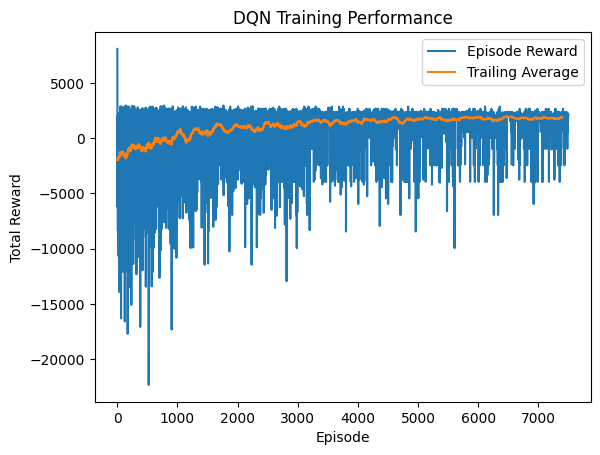

Mean reward: 2050.0 +/- 0.0


/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


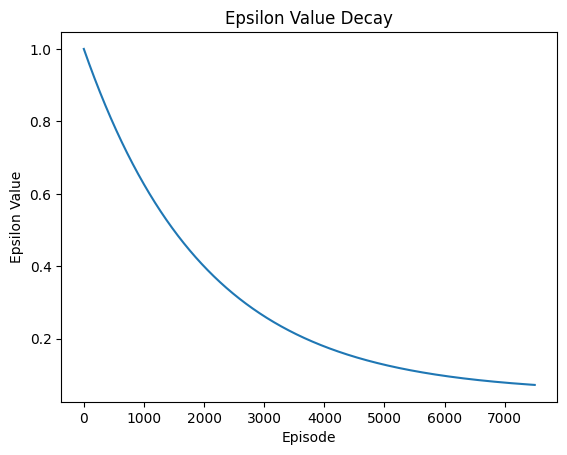

In [1238]:
import numpy as np
import matplotlib.pyplot as plt


rewards = np.array(rewards).flatten()

# Calculate the trailing average of the rewards using np.convolve
window = 100
trailing_average = np.convolve(rewards, np.ones(window), 'valid') / window

# Plotting the rewards to visualize learning
plt.plot(rewards, label='Episode Reward')
plt.plot(trailing_average, label='Trailing Average')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Performance')
plt.legend()
plt.show()

# Evaluate the trained model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward}")


# plot the epsilon values over the episodes (the values are stored as epsilon_values[episode] = epsilon)
plt.plot(epsilon_values)
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Value Decay')
plt.show()


## Testing the model

Mean reward: 2050.0 +/- 0.0


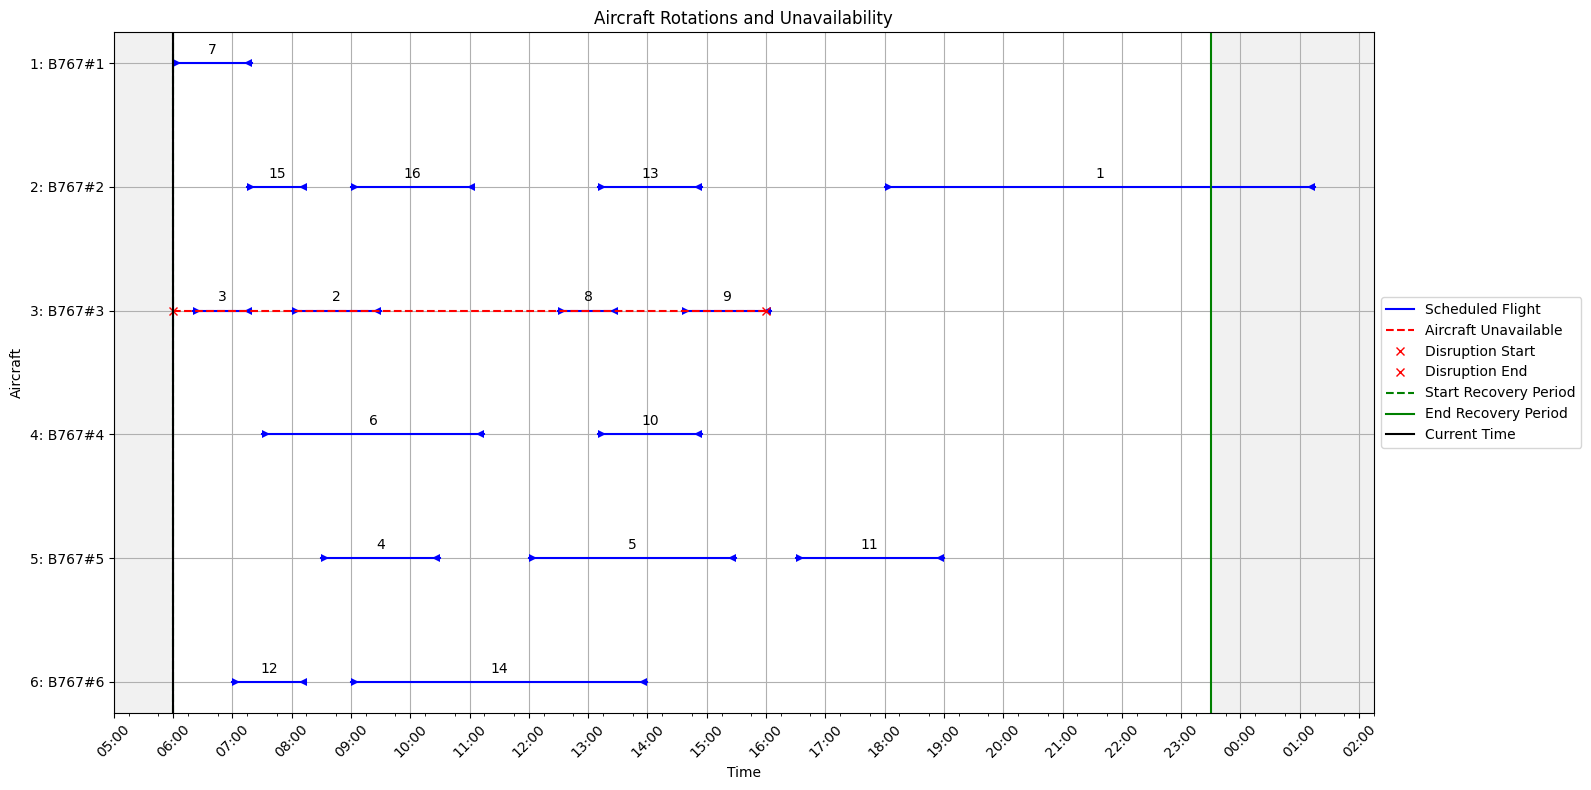

/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


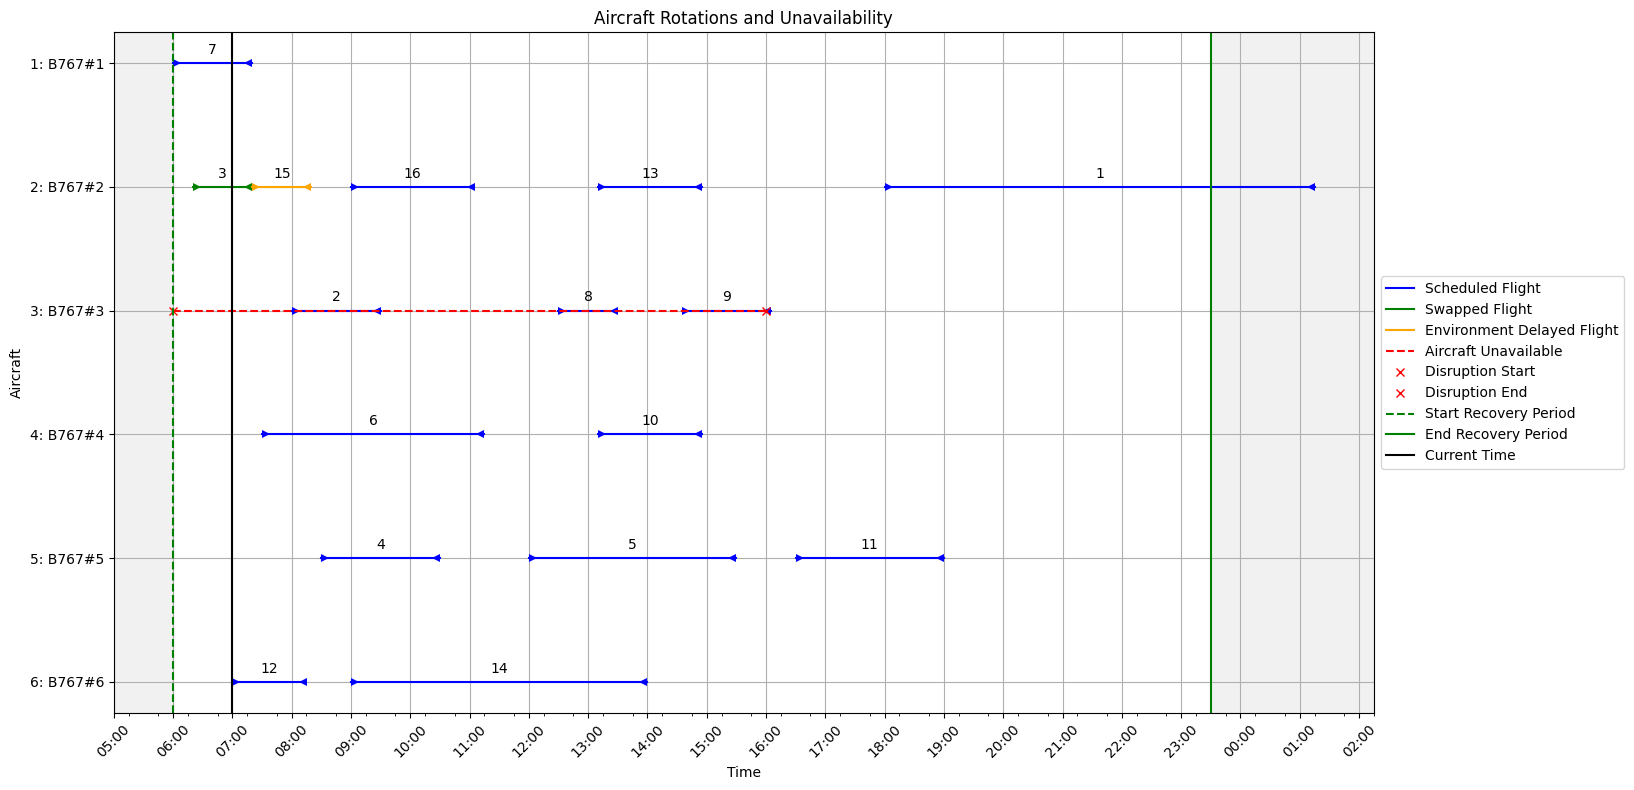

Limit flights: 5.333333333333333
Reward: [975.]
Action: [2]


/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


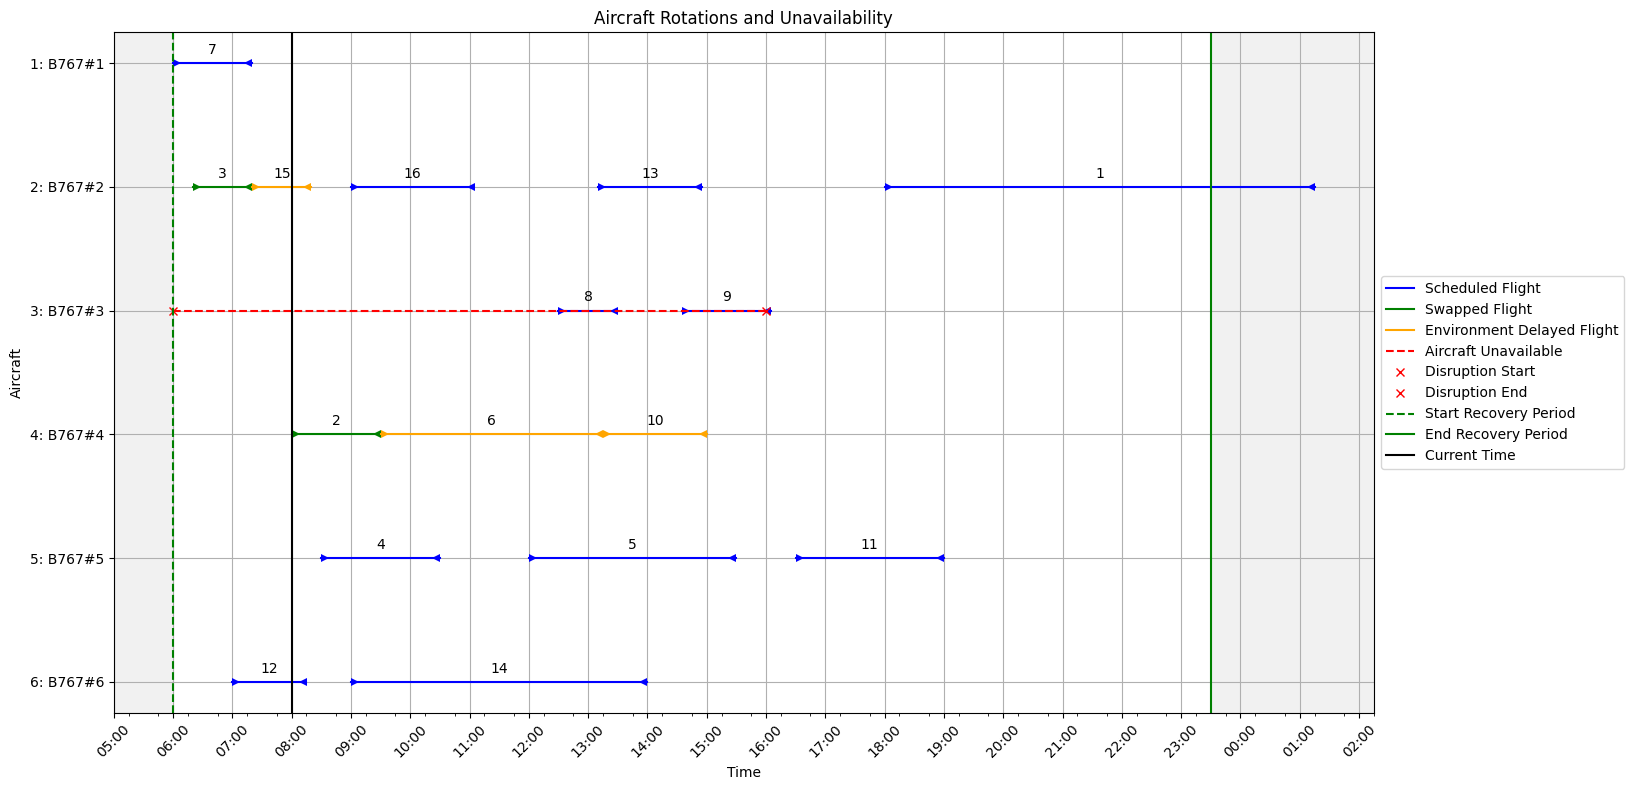

Limit flights: 5.333333333333333
Reward: [375.]
Action: [4]


/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


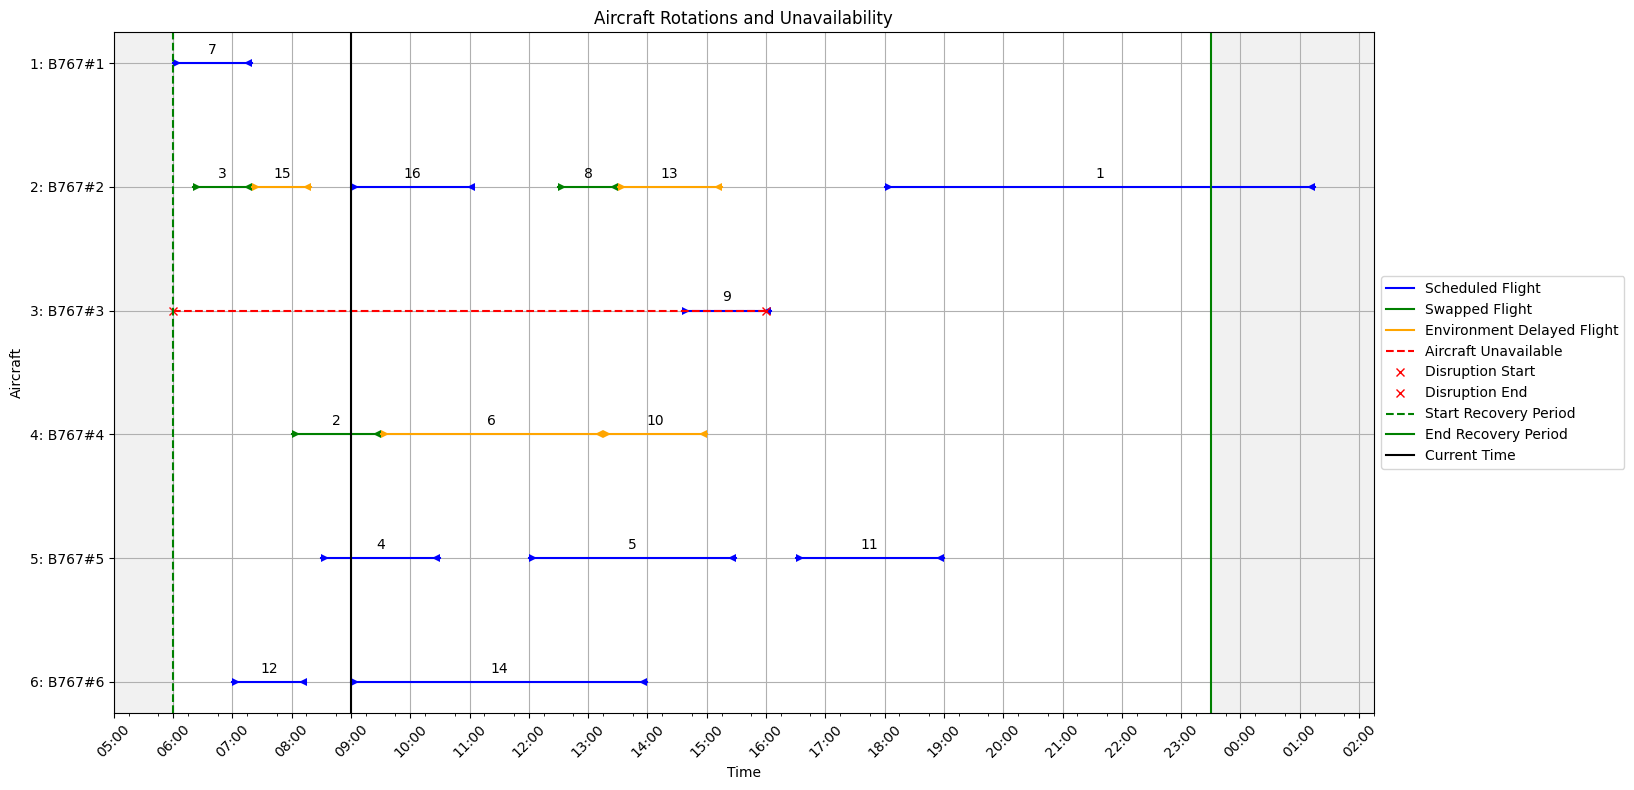

Limit flights: 5.333333333333333
Reward: [900.]
Action: [2]


/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


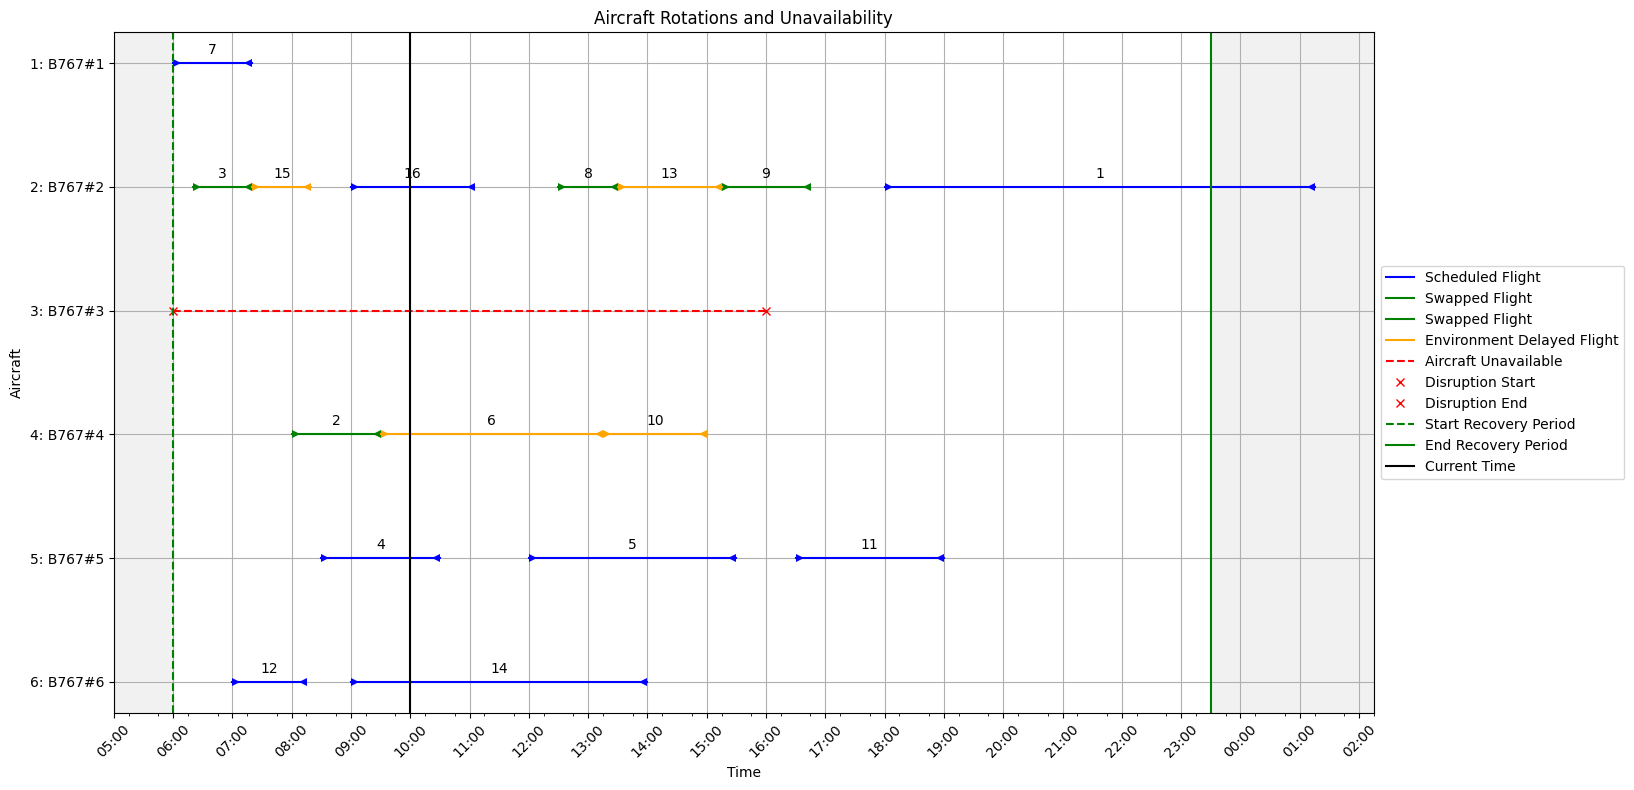

Limit flights: 5.333333333333333
Reward: [-200.]
Action: [2]


/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


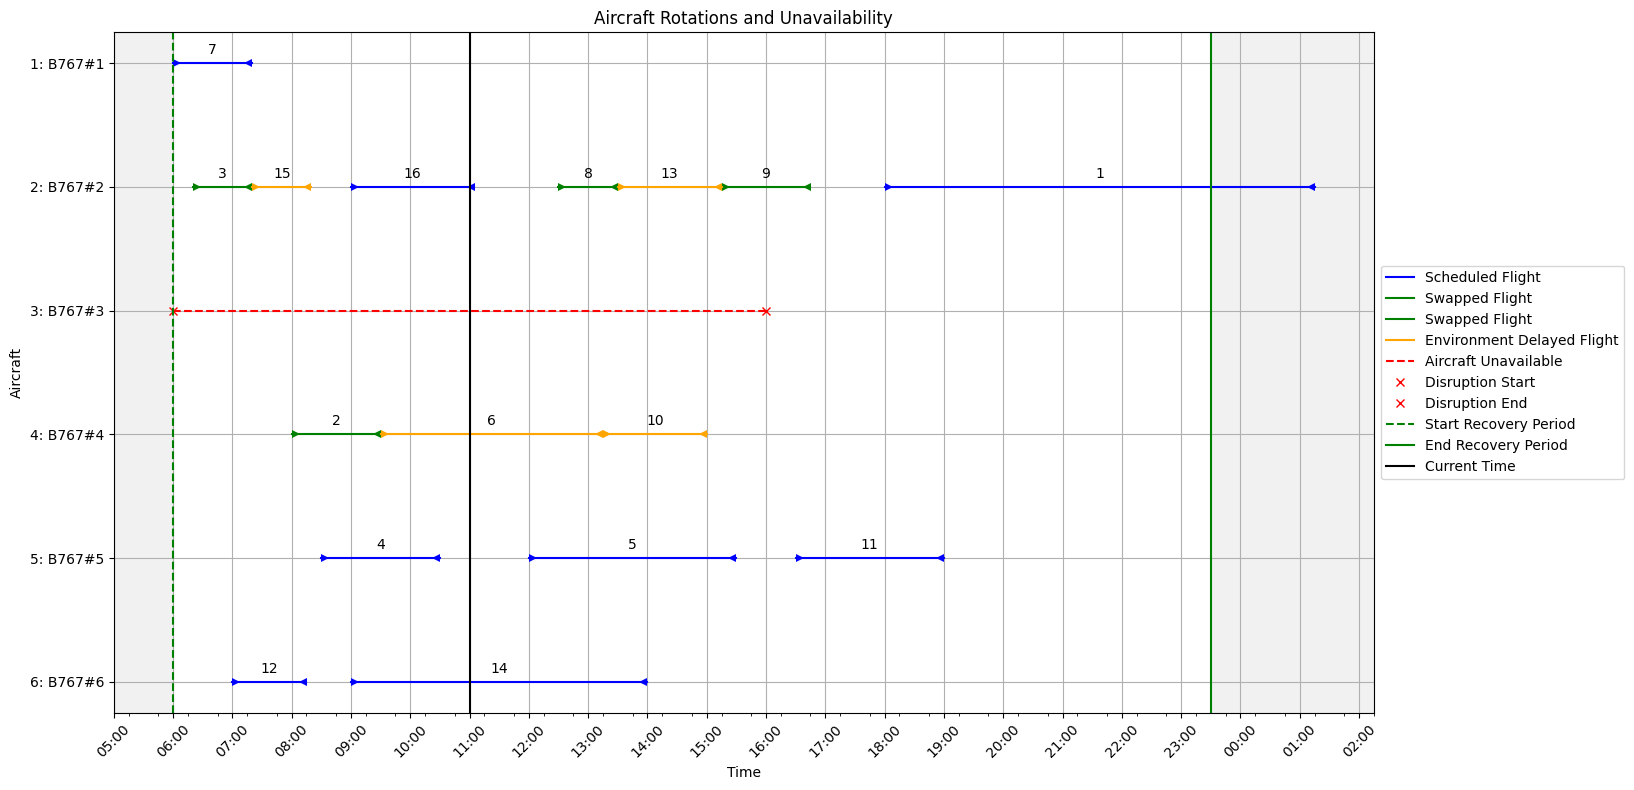

Limit flights: 5.333333333333333
Reward: [0.]
Action: [2]


/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


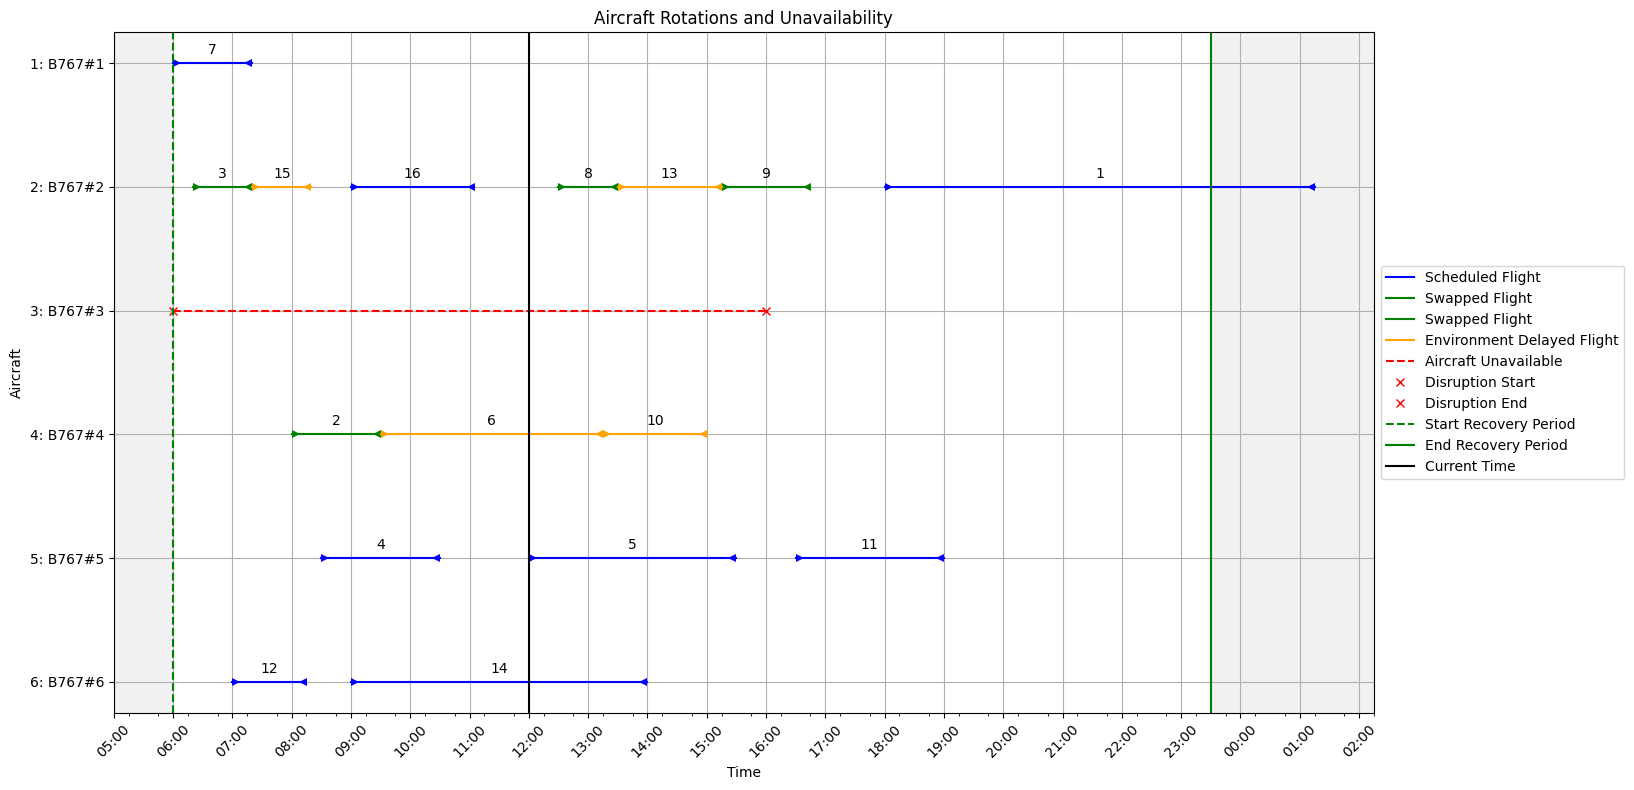

Limit flights: 5.333333333333333
Reward: [0.]
Action: [2]


/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


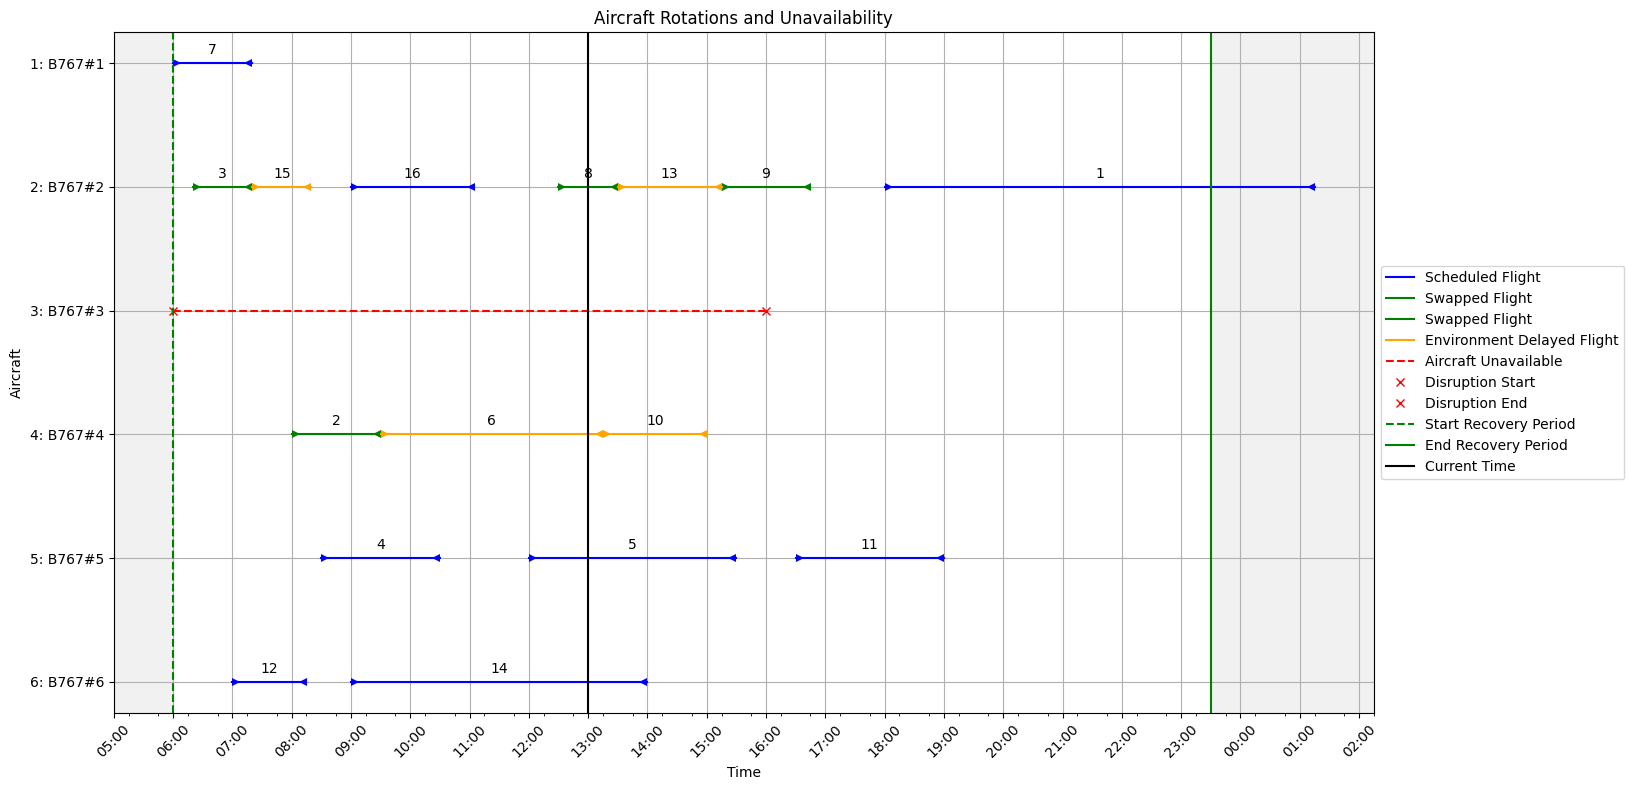

Limit flights: 5.333333333333333
Reward: [0.]
Action: [2]


/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


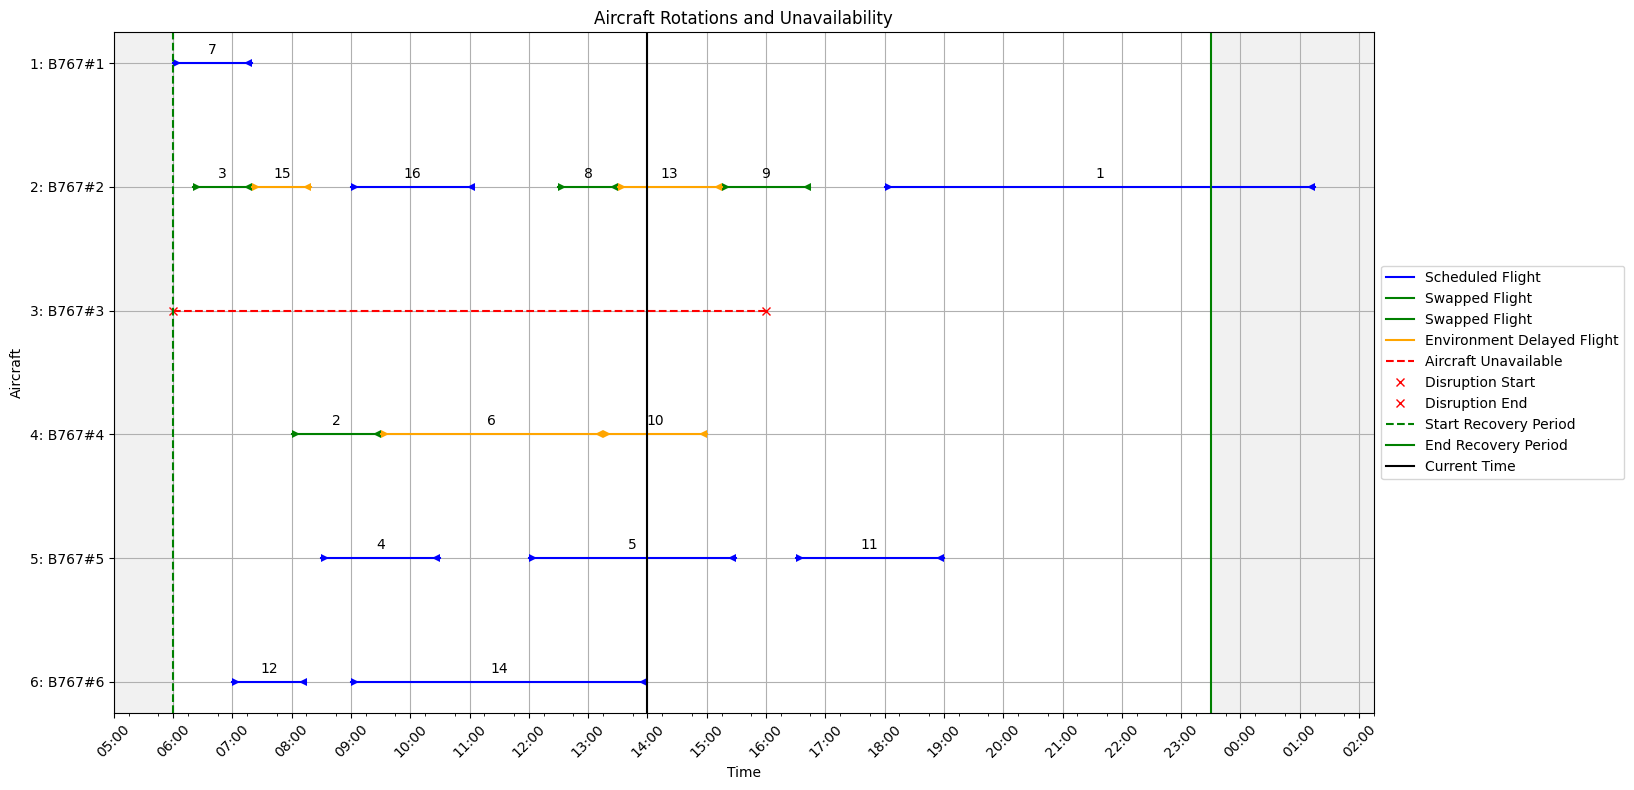

Limit flights: 5.333333333333333
Reward: [0.]
Action: [2]


/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


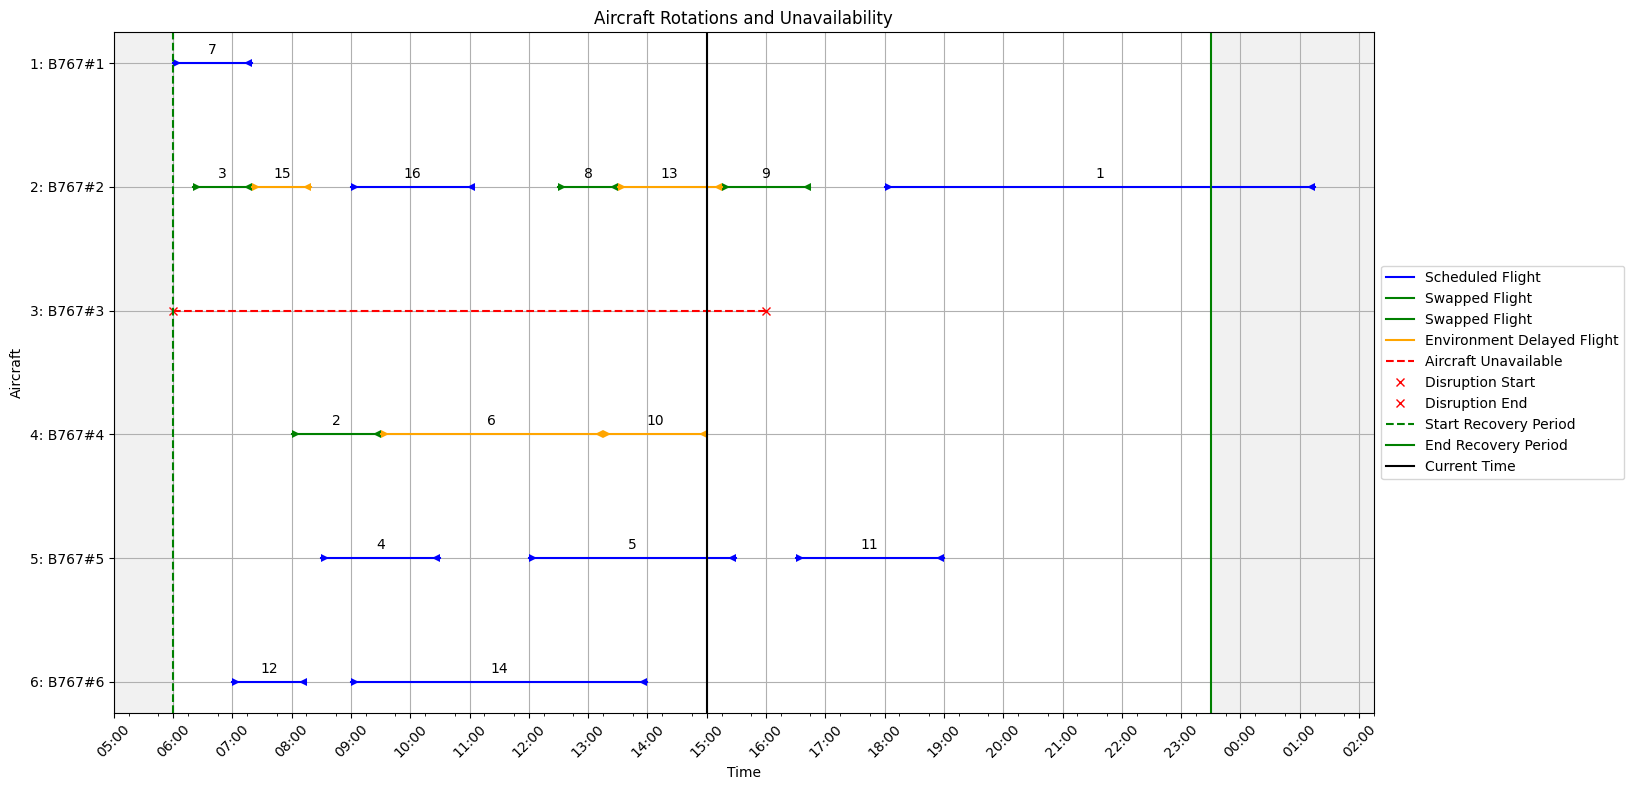

Limit flights: 5.333333333333333
Reward: [0.]
Action: [2]


/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


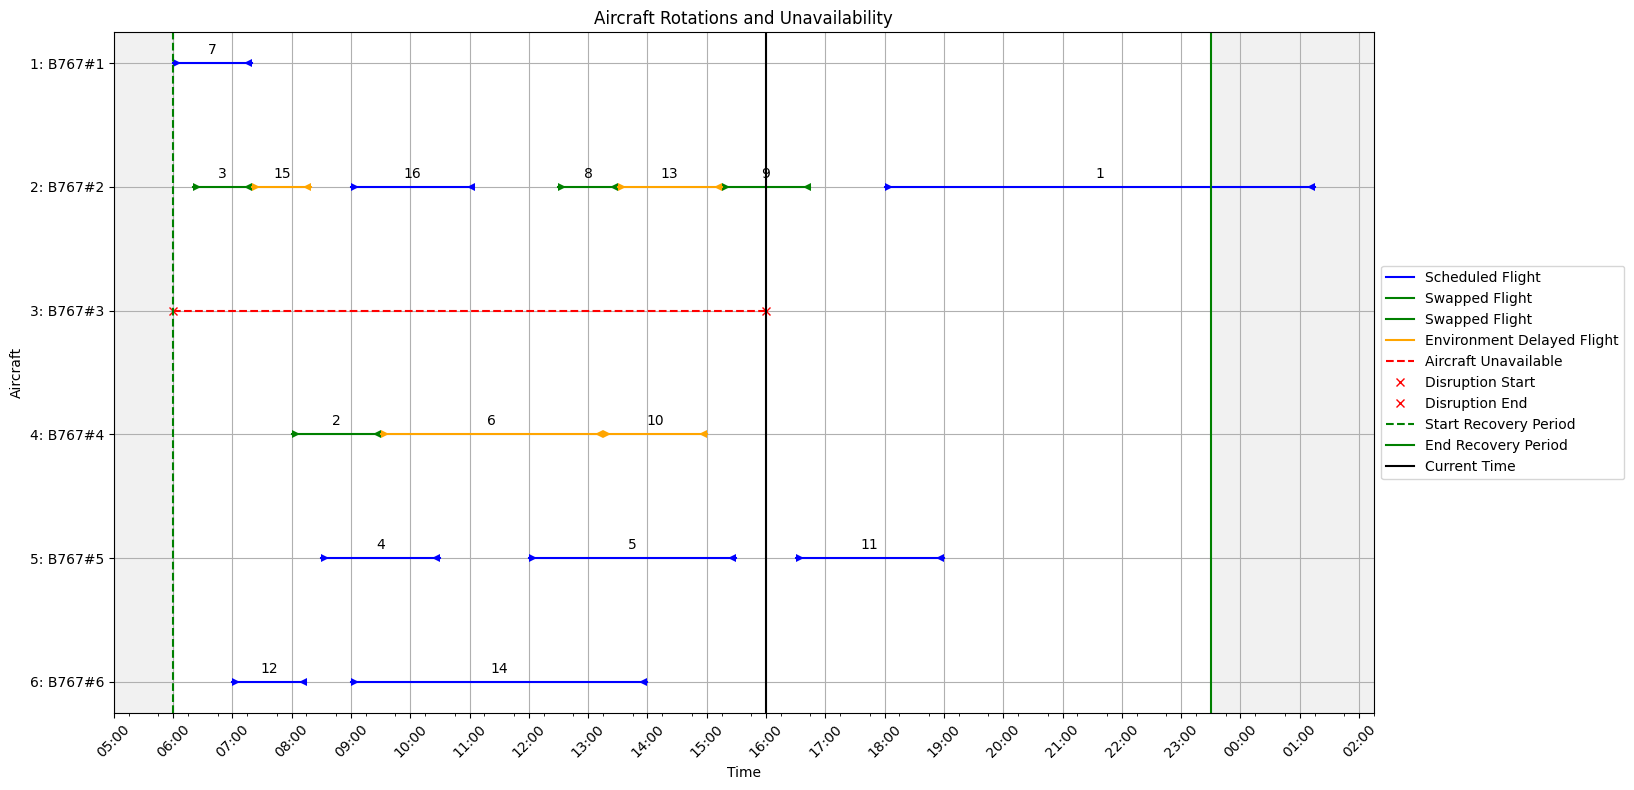

Limit flights: 5.333333333333333
Reward: [0.]
Action: [2]


/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


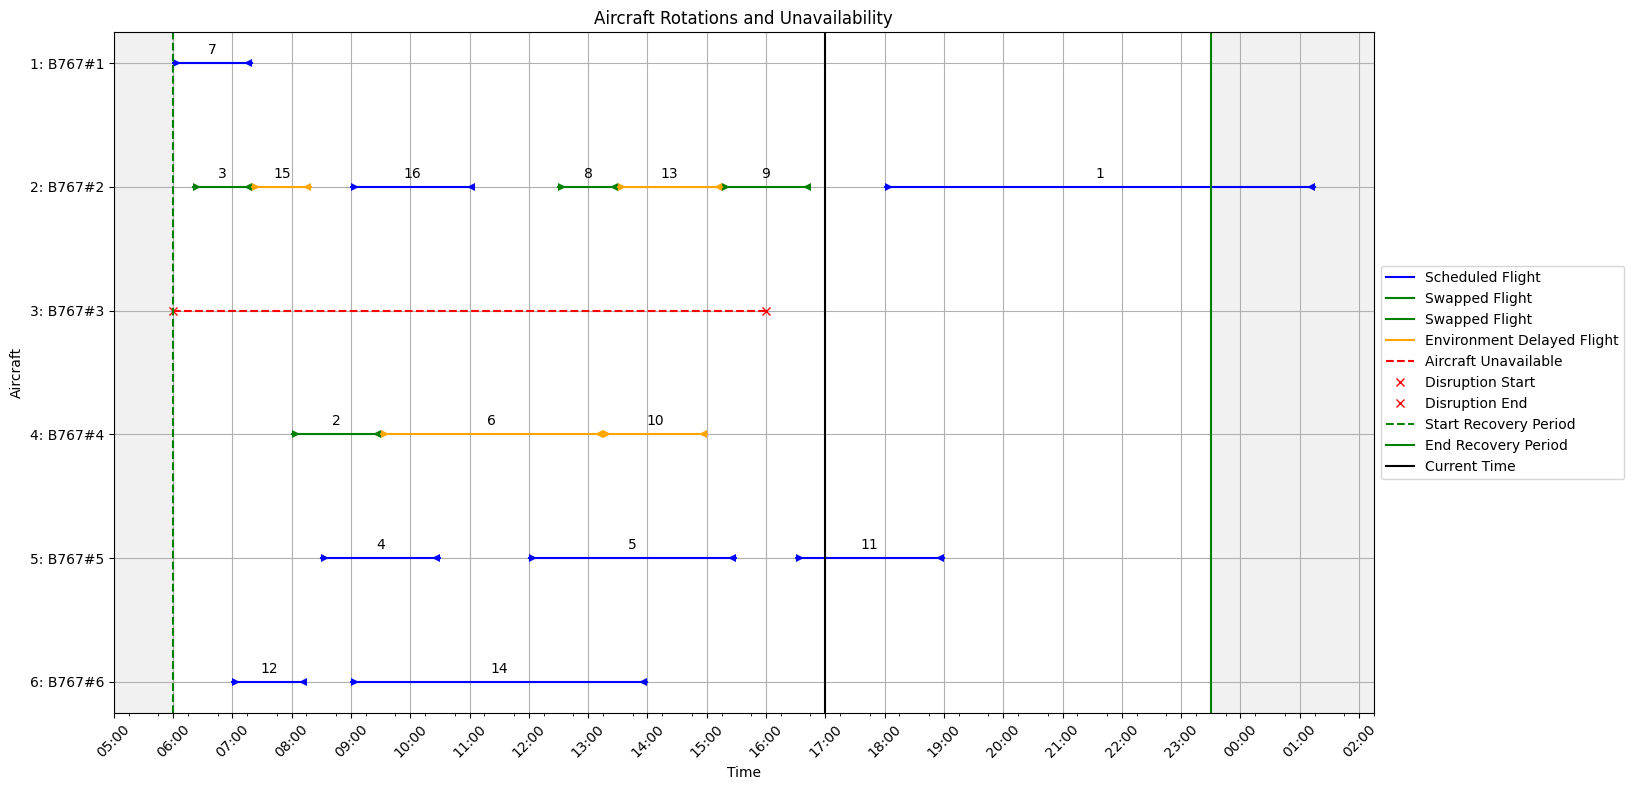

Limit flights: 5.333333333333333
Reward: [0.]
Action: [2]


/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


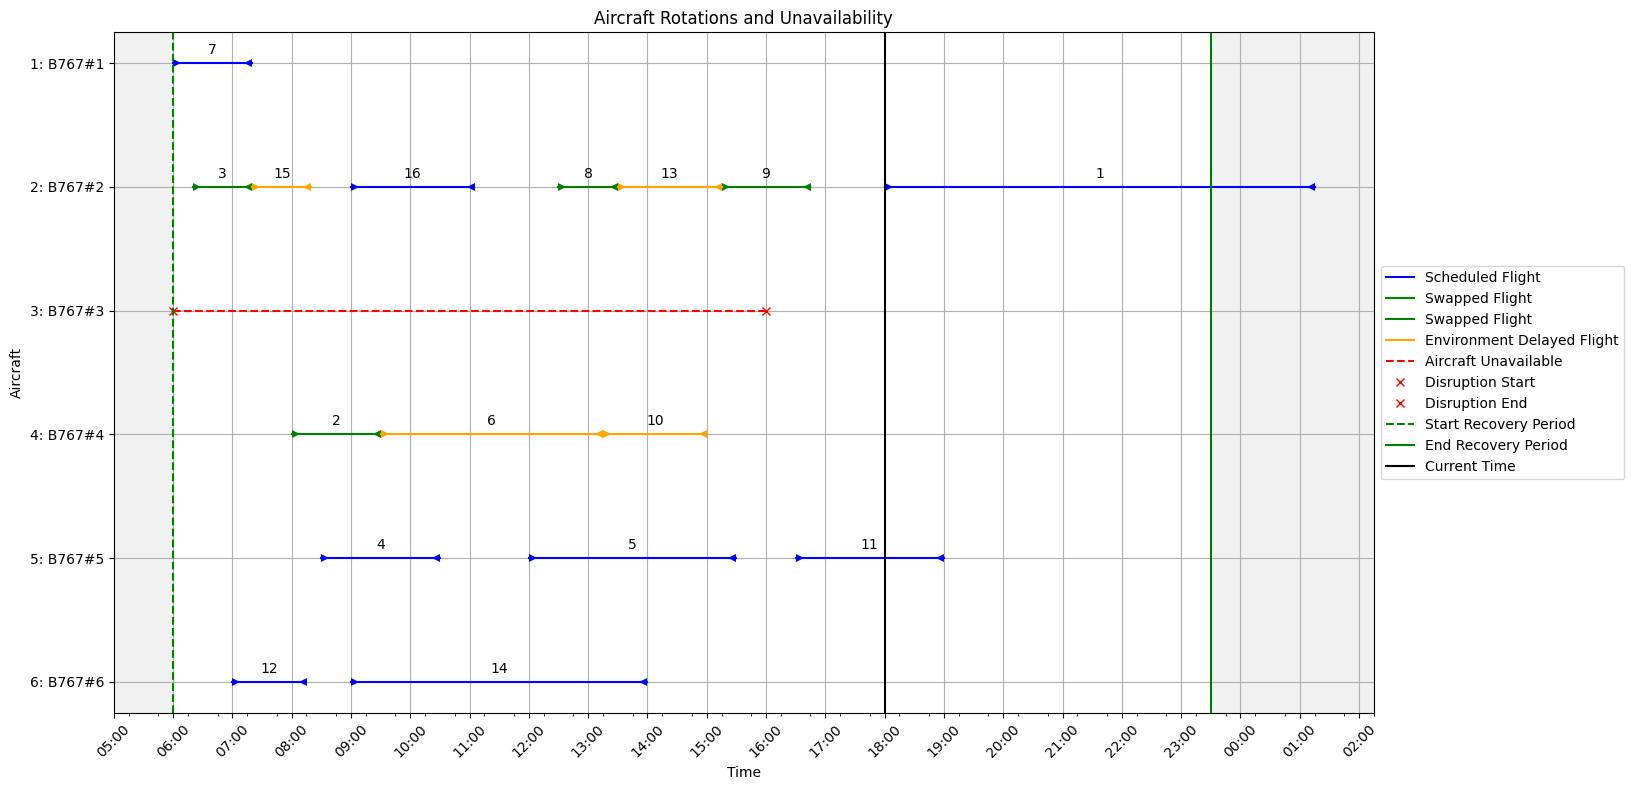

Limit flights: 5.333333333333333
Reward: [0.]
Action: [2]


/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


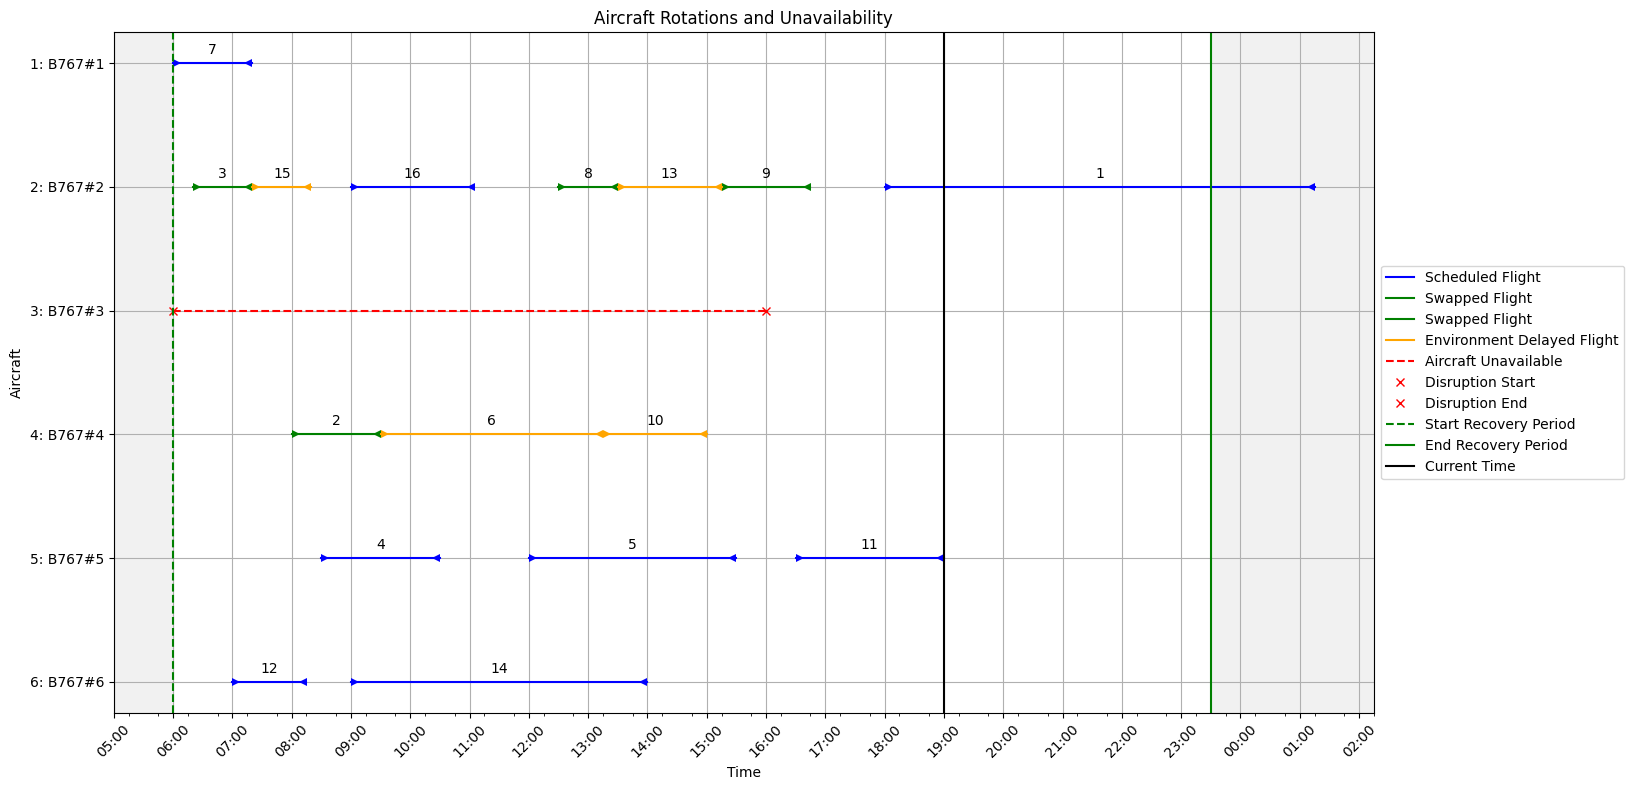

Limit flights: 5.333333333333333
Reward: [0.]
Action: [2]


/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


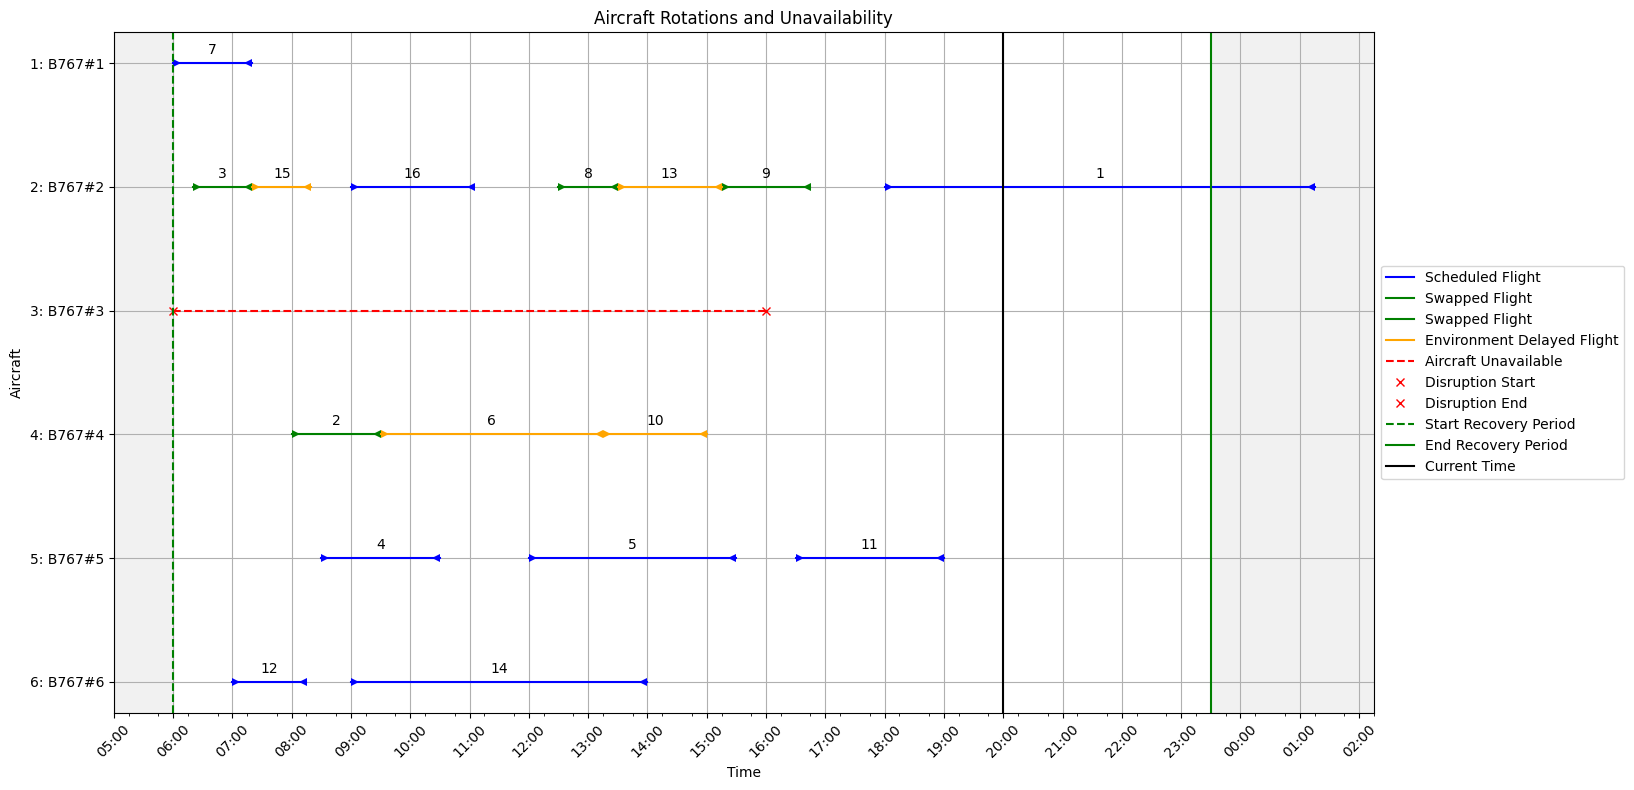

Limit flights: 5.333333333333333
Reward: [0.]
Action: [2]


/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


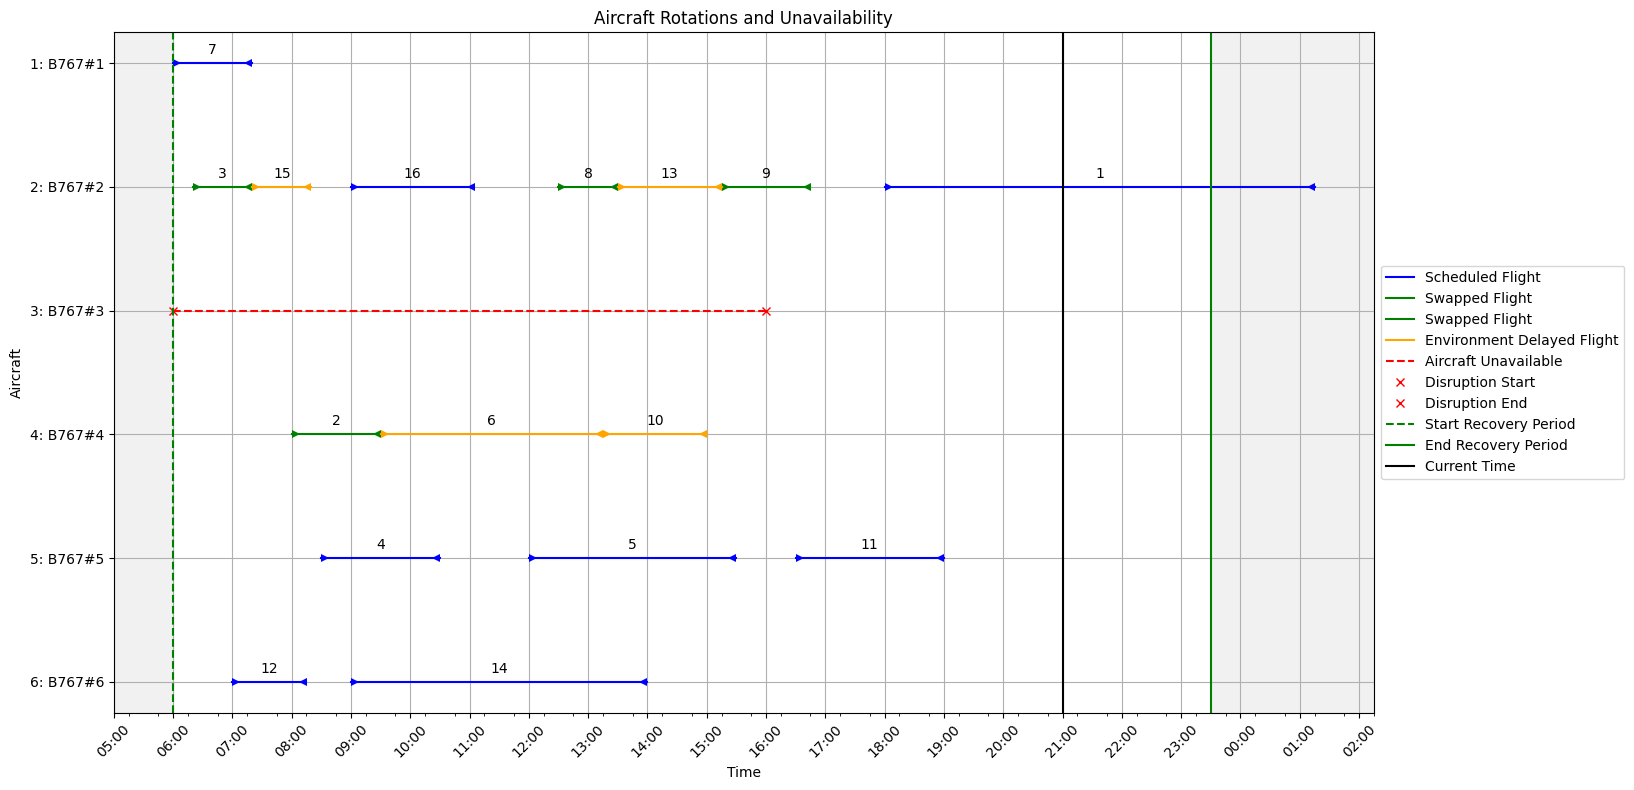

Limit flights: 5.333333333333333
Reward: [0.]
Action: [2]


/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


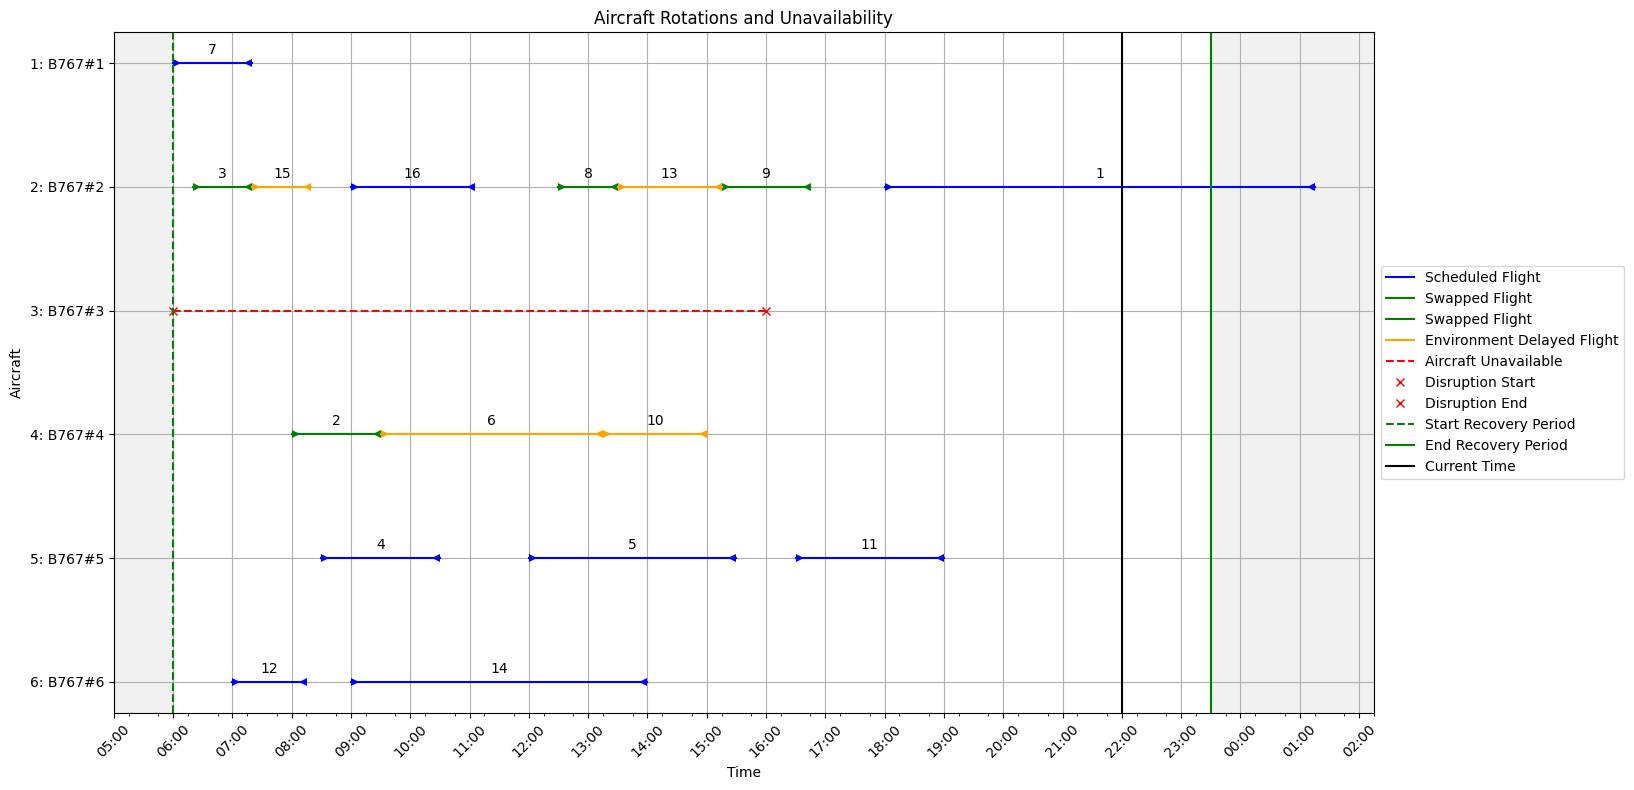

Limit flights: 5.333333333333333
Reward: [0.]
Action: [2]


/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


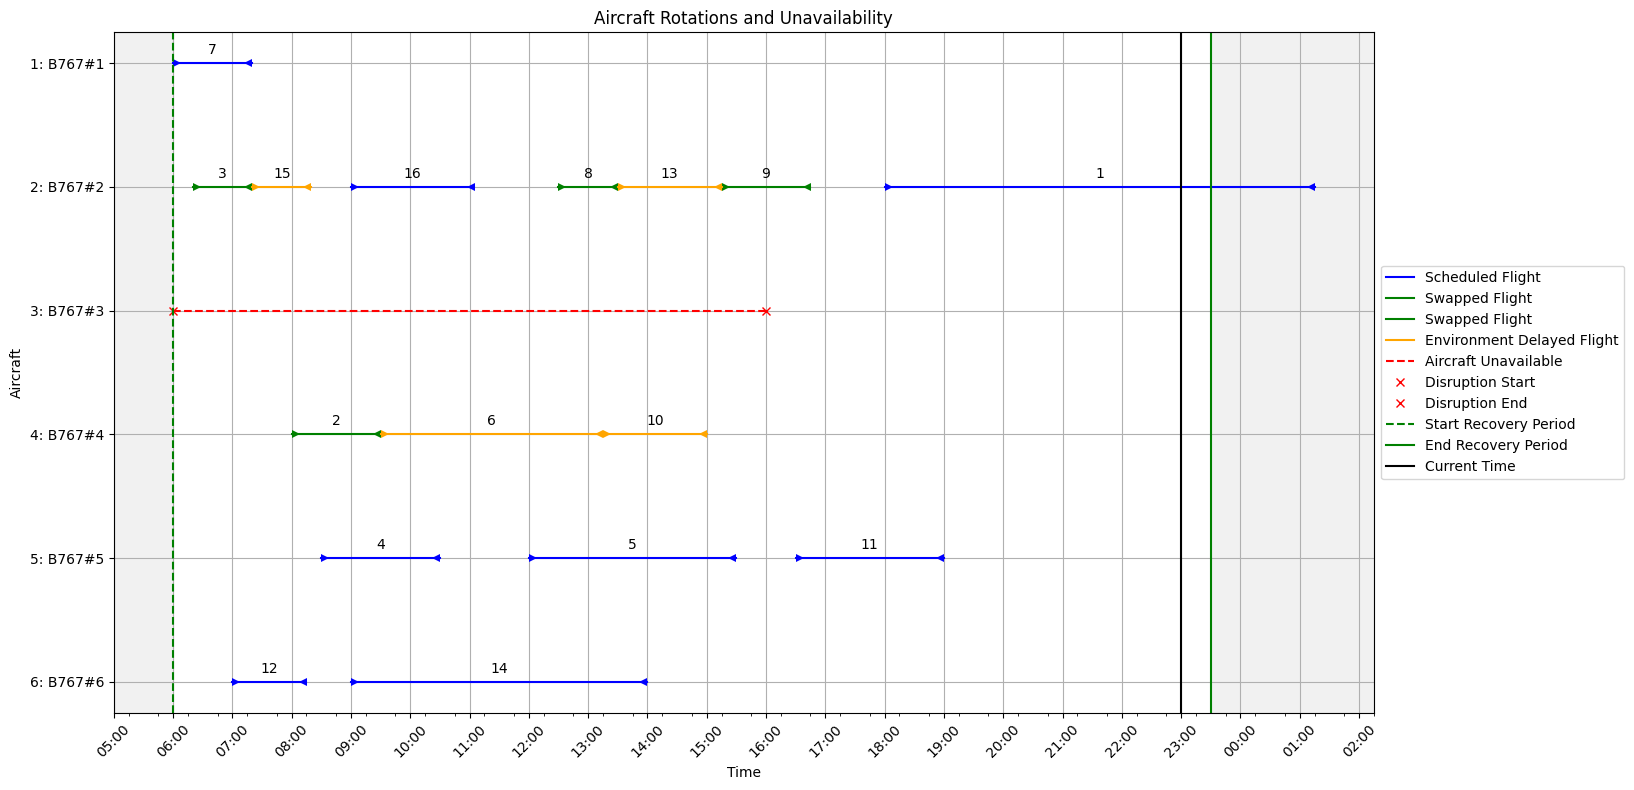

Limit flights: 5.333333333333333
Reward: [0.]
Action: [2]


/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


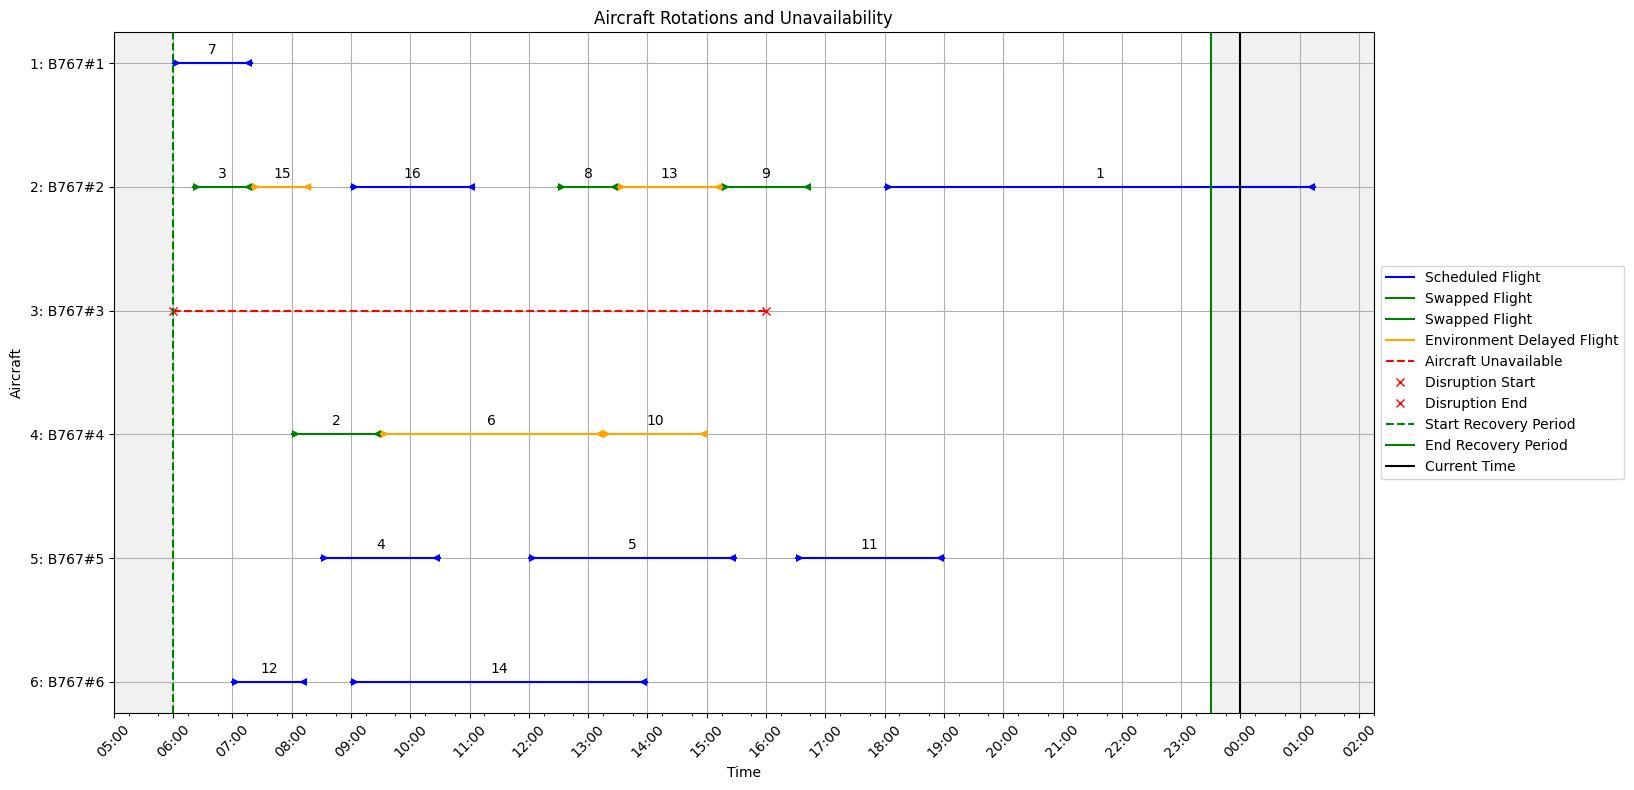

Limit flights: 5.333333333333333
Reward: [0.]
Action: [2]


/Users/pieterbecking/.pyenv/versions/thesis_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:108: RuntimeWarning: invalid value encountered in cast
  self.buf_obs[key][env_idx] = obs


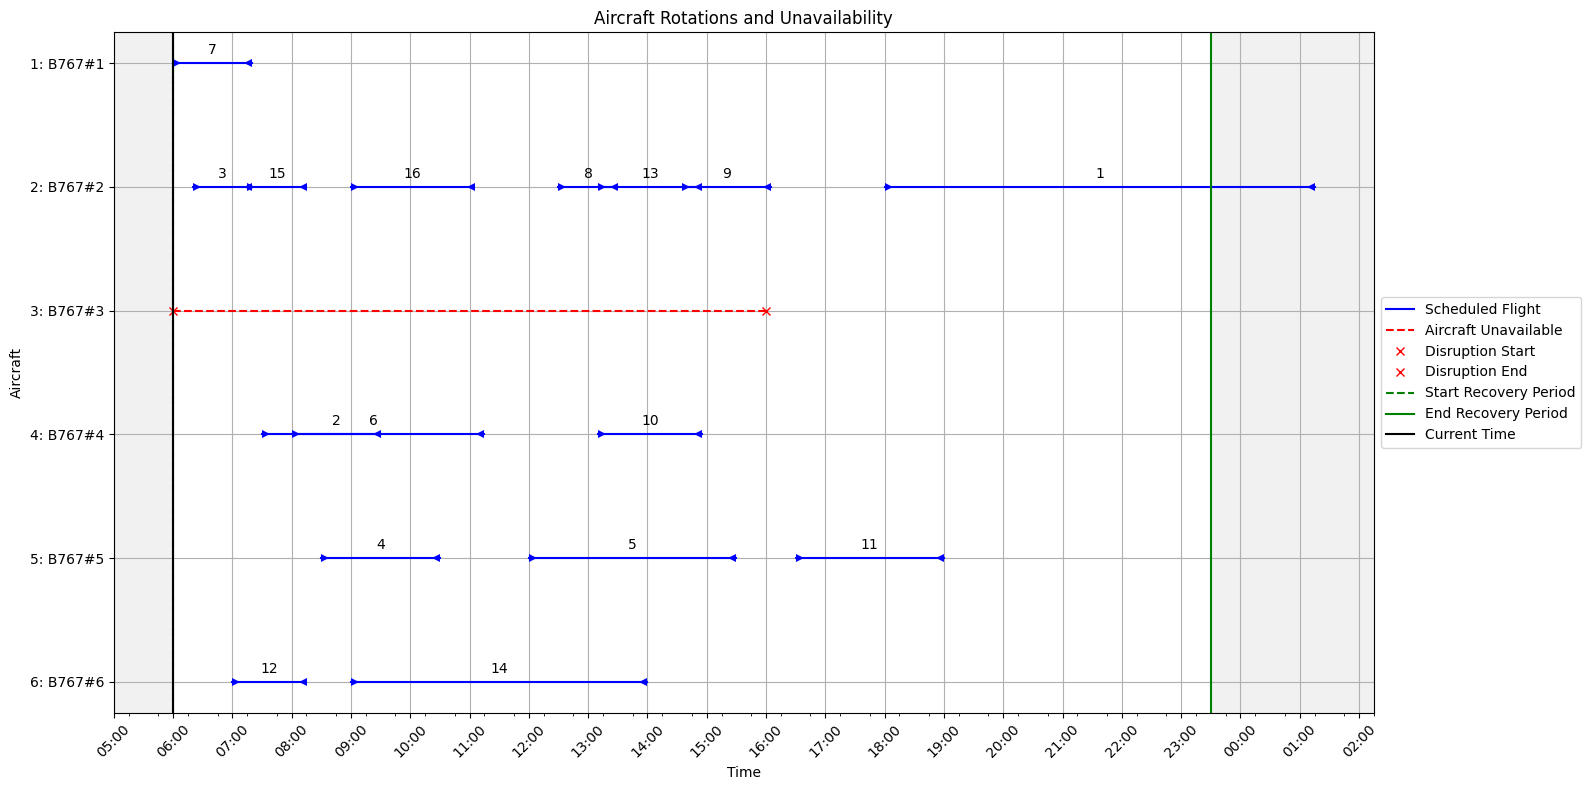

Limit flights: 5.333333333333333
Reward: [0.]
Action: [2]
Total Reward: [2050.]


In [1239]:
# Load the trained model and do one episode of evaluation
model = DQN.load("dqn_aircraft_disruption")

# Evaluate the trained model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward}")

# Access the underlying environment
real_env = env.envs[0]

# plot every step of one episode
obs = env.reset()
done = False


# plot initial state
state_plotter = StatePlotter(
    aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, 
    real_env.start_datetime, real_env.end_datetime
)
state_plotter.plot_state(
    real_env.flights_dict, real_env.swapped_flights, 
    real_env.environment_delayed_flights, real_env.current_datetime
)

total_reward = 0
while not done:
    action, _ = model.predict(obs, deterministic=False)
    obs, reward, done, _ = env.step(action)

    # Plot the state of the environment
    state_plotter = StatePlotter(
        aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, 
        real_env.start_datetime, real_env.end_datetime
    )
    state_plotter.plot_state(
        real_env.flights_dict, real_env.swapped_flights, 
        real_env.environment_delayed_flights, real_env.current_datetime
    )
    total_reward += reward
    print("Limit flights:", len(flights_dict) / len(aircraft_dict) * 2)
    print("Reward:", reward)
    print("Action:", action)
    
print("Total Reward:", total_reward)